In [3]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [4]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../ to the sys path to access the coarsegraining package
sys.path.append(pwd + '/src/')

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from coarsegrainer.plotting import plot_line_3D, plot_graph
from experimentlogger import ExperimentLogger

# Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph with quadratic bonds, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [94]:
ls results

CG_Bond_LJ_experiment2024-02-09-21.csv
CG_Bond_LJ_experiment2024-02-10-02.csv
CG_Bond_LJ_experiment2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-04.csv
CG_Bond_LJ_experiments_2024-02-10-16.csv
CG_LJ2_experiments_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-05.csv
CG_LJ2_experiments_2scale_2024-02-10-06.csv
logs/
test2024-02-09-22.csv
test2024-02-09-23.csv


In [96]:
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_Bond_LJ_experiments_2024-02-10-16.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
df = exp_logger.to_dataframe()
df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims
0,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022754,8.543608,0.05,0.1,20,1.000000e-06,1.836791,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Energy_Bond_LJ,CG_Bond_LJ0.33_n400_d3,-0.023195,11.070001,0.05,0.1,20,1.000000e-06,1.836791,400,0.050,20.0,0.000010,405.0,8.181297,-0.022475,NaN,NaN
2,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023063,14.817611,0.05,0.1,20,1.000000e-06,1.836791,400,0.005,20.0,0.000010,466.0,11.557696,-0.022810,133.0,"[8, 4, 3]"
3,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023160,12.972471,0.05,0.1,20,1.000000e-06,1.836791,400,0.005,20.0,0.000010,269.0,6.974455,-0.022601,133.0,"[32, 16, 3]"
4,Energy_Bond_LJ,CG_Bond_LJ0.25_n400_d3,-0.022552,11.890551,0.05,0.1,20,1.000000e-06,1.836791,400,0.050,20.0,0.000010,422.0,8.777099,-0.020056,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.023028,18.204283,0.05,0.1,20,1.000000e-07,1.836791,400,0.050,20.0,0.000001,617.0,15.209863,-0.022077,100.0,"[8, 4, 3]"
148,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.021621,7.162053,0.05,0.1,20,1.000000e-07,1.836791,400,0.050,20.0,0.000001,263.0,6.811737,0.038649,100.0,"[32, 16, 3]"
149,Energy_Bond_LJ,CG_Bond_LJ0.20_n400_d3,-0.000680,1.810635,0.05,0.1,20,1.000000e-07,1.836791,400,0.500,20.0,0.000001,54.0,1.417656,0.001859,NaN,NaN
150,Energy_Bond_LJ,GNN_Bond_LJ0.20_n400_d3,-0.023014,9.096297,0.05,0.1,20,1.000000e-07,1.836791,400,0.050,20.0,0.000001,231.0,6.021744,-0.022002,80.0,"[8, 4, 3]"


In [97]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']
df[:10]

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims,cg_ratio
0,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022754,8.543608,0.05,0.1,20,0.000001,1.836791,400,NaN,NaN,NaN,NaN,NaN,NaN,400.0,NaN,1.00
1,Energy_Bond_LJ,CG_Bond_LJ0.33_n400_d3,-0.023195,11.070001,0.05,0.1,20,0.000001,1.836791,400,0.050,20.0,0.00001,405.0,8.181297,-0.022475,132.0,NaN,0.33
2,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023063,14.817611,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,466.0,11.557696,-0.022810,132.0,"[8, 4, 3]",0.33
3,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023160,12.972471,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,269.0,6.974455,-0.022601,132.0,"[32, 16, 3]",0.33
4,Energy_Bond_LJ,CG_Bond_LJ0.25_n400_d3,-0.022552,11.890551,0.05,0.1,20,0.000001,1.836791,400,0.050,20.0,0.00001,422.0,8.777099,-0.020056,100.0,NaN,0.25
5,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.023146,21.659890,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,620.0,15.475063,-0.022653,100.0,"[8, 4, 3]",0.25
6,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.019123,7.026602,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,256.0,6.655472,-0.011929,100.0,"[32, 16, 3]",0.25
7,Energy_Bond_LJ,CG_Bond_LJ0.20_n400_d3,0.019693,11.531193,0.05,0.1,20,0.000001,1.836791,400,0.050,20.0,0.00001,429.0,8.934613,0.023910,80.0,NaN,0.20
8,Energy_Bond_LJ,GNN_Bond_LJ0.20_n400_d3,0.019770,17.694227,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,616.0,14.709538,0.019986,80.0,"[8, 4, 3]",0.20
9,Energy_Bond_LJ,GNN_Bond_LJ0.20_n400_d3,-0.021371,5.907160,0.05,0.1,20,0.000001,1.836791,400,0.005,20.0,0.00001,220.0,5.556619,-0.015677,80.0,"[32, 16, 3]",0.20


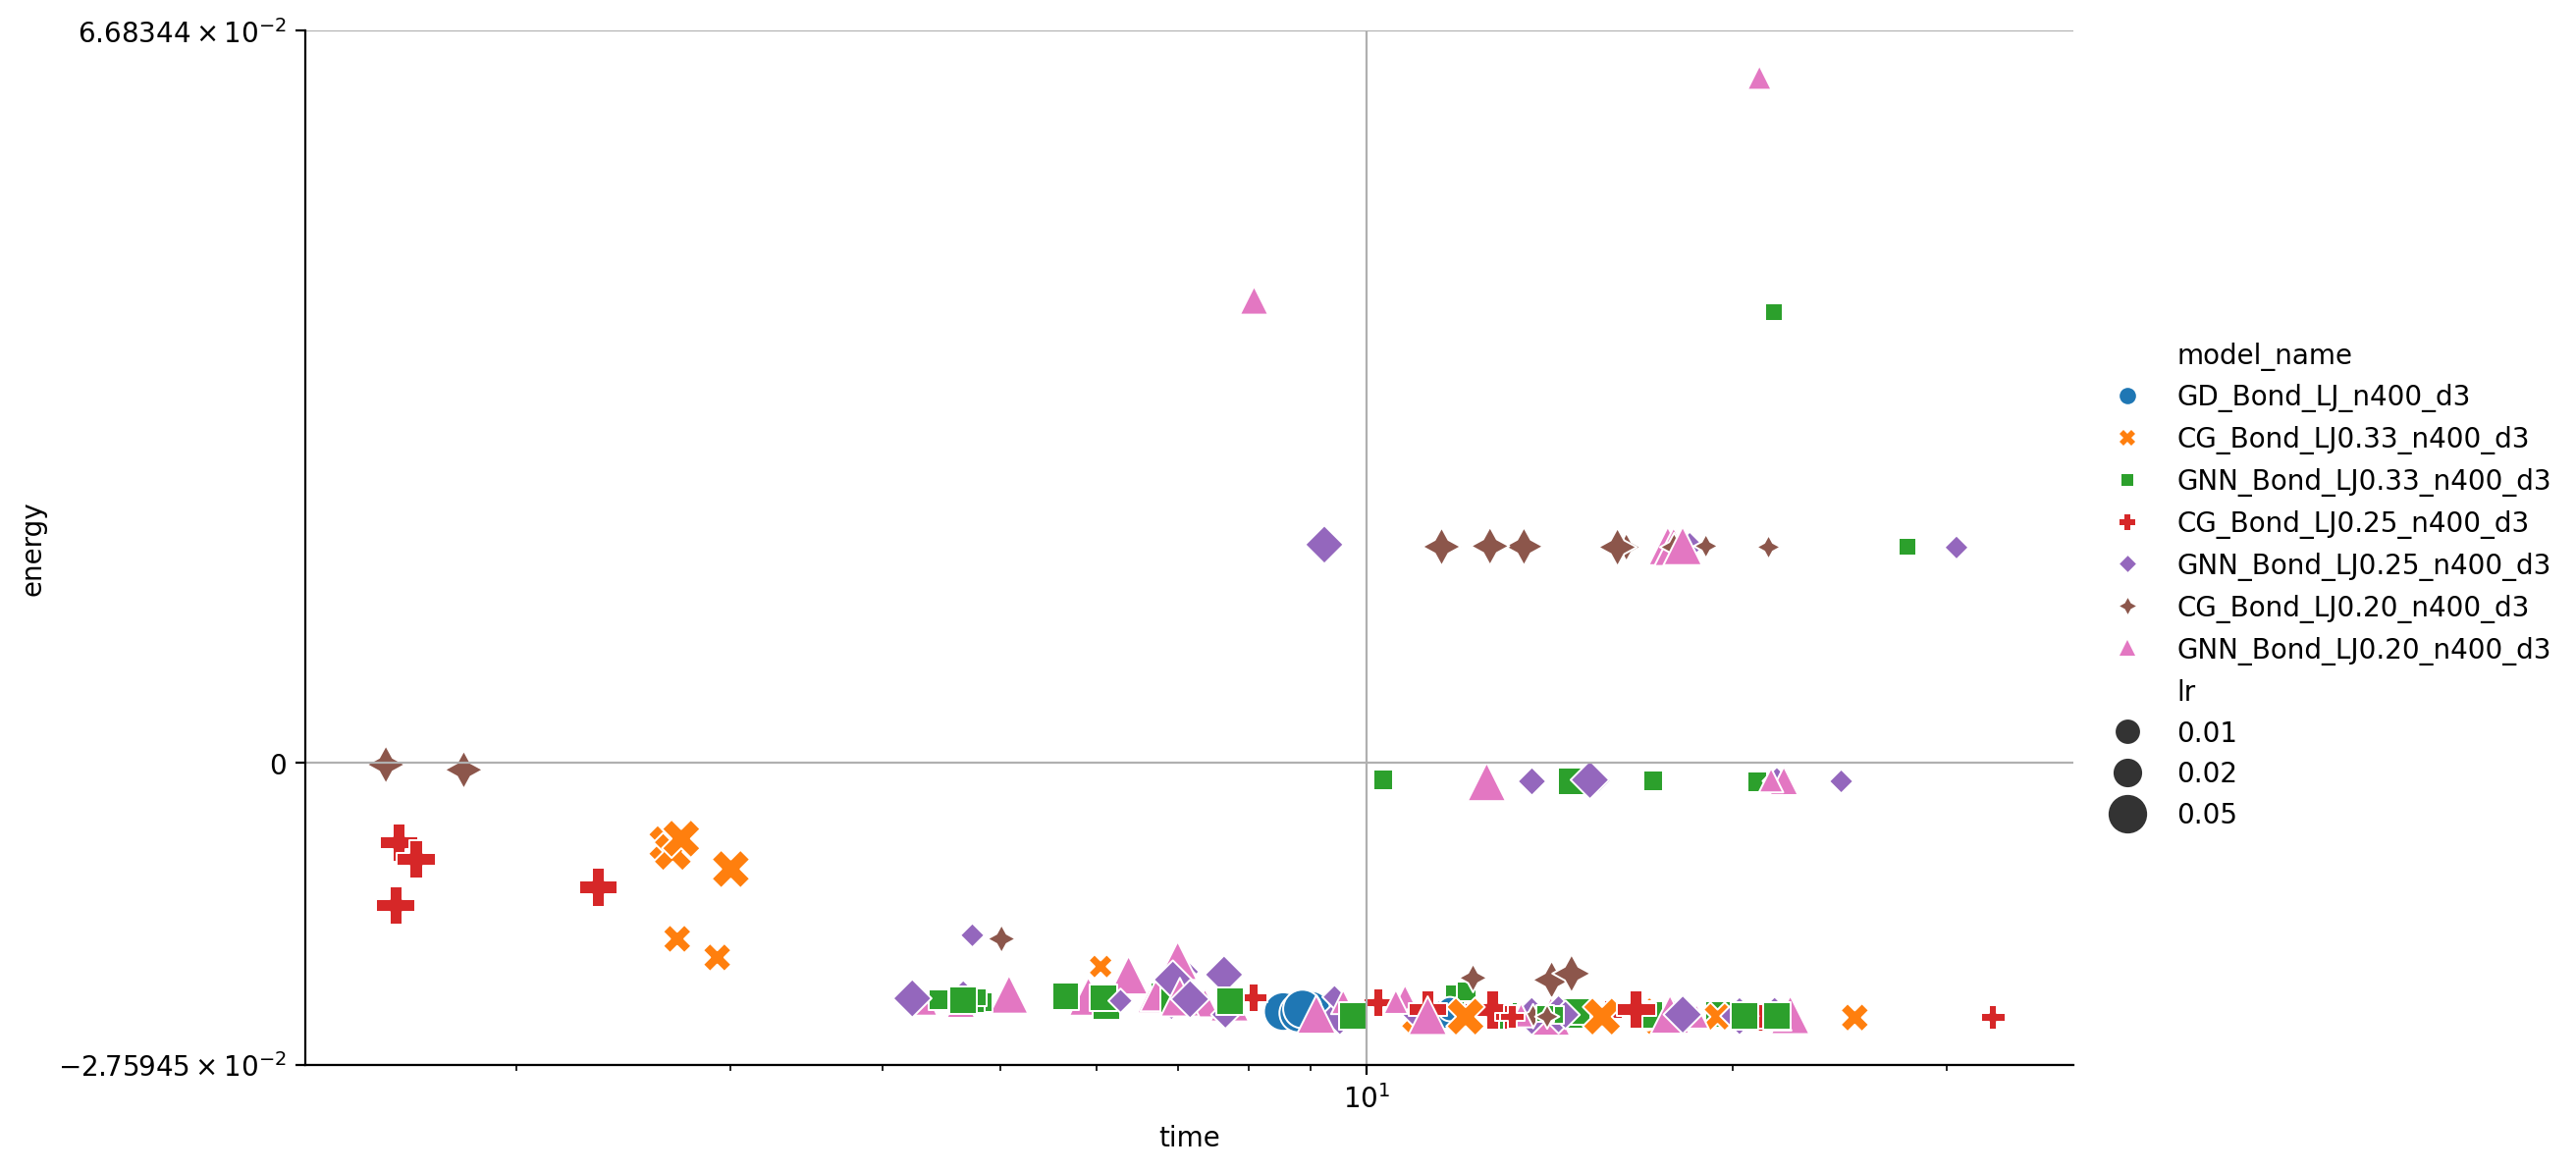

In [98]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.0234, -.0228)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

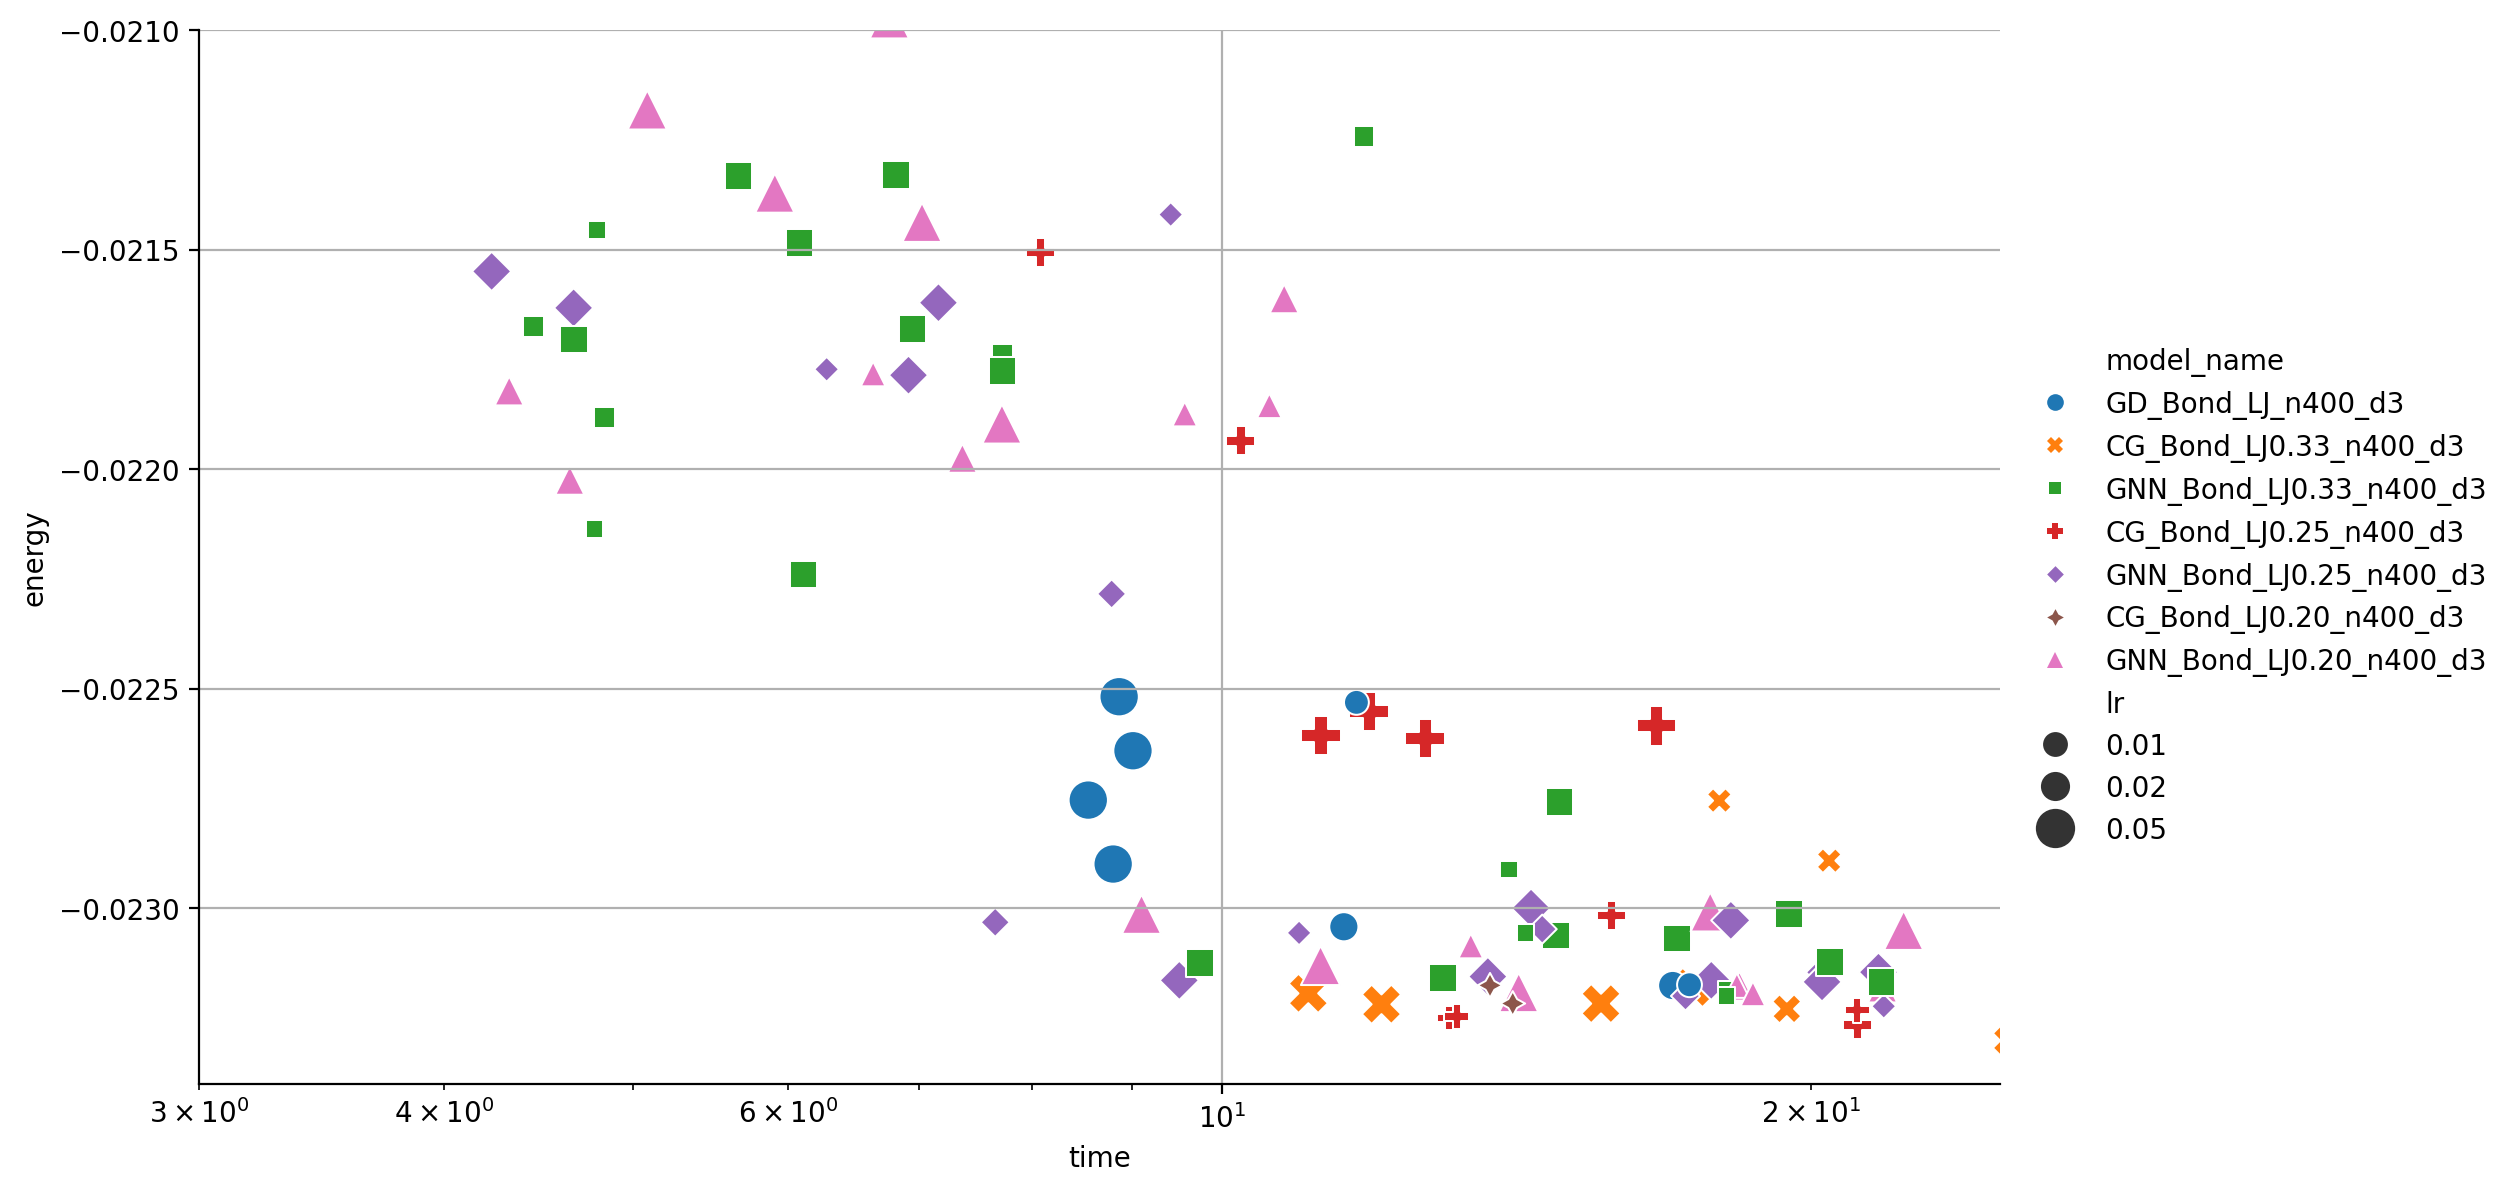

In [99]:
# df = exp_logger.to_dataframe()
# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.0210)
plt.xlim(3,25)
plt.xscale('log')
plt.grid()

## Grouping similar runs

In [100]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'min_delta', 'num_cg_modes', 'lr_cg', 'hidden_dims'])
# other options: cg_patience,cg_min_delta
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1651258/3992581159.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1651258/3992581159.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr     min_delta num_cg_modes  lr_cg  \
                                                                       
0     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07         80.0  0.010   
1     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-07         80.0  0.100   
2     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06         80.0  0.010   
3     CG_Bond_LJ0.20_n400_d3  0.01  1.000000e-06         80.0  0.100   
4     CG_Bond_LJ0.20_n400_d3  0.02  1.000000e-07         80.0  0.020   
..                       ...   ...           ...          ...    ...   
109  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-07        132.0  0.050   
110  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
111  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
112  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   
113  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   

     hidden_dims    energy                 time            
                      mean       std       mean       std  
0            NaN  0.019654       NaN  21.414942       NaN  
1            NaN -0.023218       NaN  14.081982       NaN  
2            NaN  0.019747       NaN  19.020253       NaN  
3            NaN -0.023176       NaN  13.710245       NaN  
4            NaN  0.019654       NaN  17.910306       NaN  
..           ...       ...       ...        ...       ...  
109    [8, 4, 3] -0.023091  0.000109  20.618664  1.584142  
110  [32, 16, 3] -0.022245  0.001294   9.892986  4.355049  
111    [8, 4, 3] -0.023066  0.000005  15.950243  1.601783  
112  [32, 16, 3] -0.022229  0.001267   7.703062  2.890561  
113    [8, 4, 3] -0.011759  0.014166  11.234873  4.967021  

[114 rows x 10 columns]

In [101]:
df_copy

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims,cg_ratio
0,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022754,8.543608,0.05,0.1,20,1.000000e-06,1.836791,400,na,na,na,na,na,na,400.0,na,1.00
1,Energy_Bond_LJ,CG_Bond_LJ0.33_n400_d3,-0.023195,11.070001,0.05,0.1,20,1.000000e-06,1.836791,400,0.05,20.0,0.00001,405.0,8.181297,-0.022475,132.0,na,0.33
2,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023063,14.817611,0.05,0.1,20,1.000000e-06,1.836791,400,0.005,20.0,0.00001,466.0,11.557696,-0.02281,132.0,"[8, 4, 3]",0.33
3,Energy_Bond_LJ,GNN_Bond_LJ0.33_n400_d3,-0.023160,12.972471,0.05,0.1,20,1.000000e-06,1.836791,400,0.005,20.0,0.00001,269.0,6.974455,-0.022601,132.0,"[32, 16, 3]",0.33
4,Energy_Bond_LJ,CG_Bond_LJ0.25_n400_d3,-0.022552,11.890551,0.05,0.1,20,1.000000e-06,1.836791,400,0.05,20.0,0.00001,422.0,8.777099,-0.020056,100.0,na,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.023028,18.204283,0.05,0.1,20,1.000000e-07,1.836791,400,0.05,20.0,0.000001,617.0,15.209863,-0.022077,100.0,"[8, 4, 3]",0.25
148,Energy_Bond_LJ,GNN_Bond_LJ0.25_n400_d3,-0.021621,7.162053,0.05,0.1,20,1.000000e-07,1.836791,400,0.05,20.0,0.000001,263.0,6.811737,0.038649,100.0,"[32, 16, 3]",0.25
149,Energy_Bond_LJ,CG_Bond_LJ0.20_n400_d3,-0.000680,1.810635,0.05,0.1,20,1.000000e-07,1.836791,400,0.5,20.0,0.000001,54.0,1.417656,0.001859,80.0,na,0.20
150,Energy_Bond_LJ,GNN_Bond_LJ0.20_n400_d3,-0.023014,9.096297,0.05,0.1,20,1.000000e-07,1.836791,400,0.05,20.0,0.000001,231.0,6.021744,-0.022002,80.0,"[8, 4, 3]",0.20


In [102]:
# get rows where  model_name starts with 'GD_'
df_gd = df_copy[df_copy['model_name'].str.startswith('GD_')]
df_gd


,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims,cg_ratio
0,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022754,8.543608,0.05,0.1,20,1.000000e-06,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
19,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022642,9.005259,0.05,0.1,20,1.000000e-07,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
38,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.023177,17.000027,0.02,0.1,20,1.000000e-06,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
57,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.023043,11.542883,0.02,0.1,20,1.000000e-07,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
76,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022532,11.715016,0.01,0.1,20,1.000000e-06,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
95,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.023175,17.339687,0.01,0.1,20,1.000000e-07,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
114,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022900,8.797736,0.05,0.1,20,1.000000e-06,1.836791,400,na,na,na,na,na,na,400.0,na,1.0
133,Energy_Bond_LJ,GD_Bond_LJ_n400_d3,-0.022519,8.859826,0.05,0.1,20,1.000000e-07,1.836791,400,na,na,na,na,na,na,400.0,na,1.0


In [103]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
# df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered = df_mean #[df_mean['energy']['std'] < std_threshold]

df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

In [104]:
df_filtered

,index,model_name,lr,min_delta,num_cg_modes,lr_cg,hidden_dims,energy-mean,energy-std,time-mean,time-std,energy_mean,energy_std,time_mean,time_std
0,0,CG_Bond_LJ0.20_n400_d3,0.01,1.000000e-07,80.0,0.010,NaN,0.019654,NaN,21.414942,NaN,0.019654,NaN,21.414942,NaN
1,1,CG_Bond_LJ0.20_n400_d3,0.01,1.000000e-07,80.0,0.100,NaN,-0.023218,NaN,14.081982,NaN,-0.023218,NaN,14.081982,NaN
2,2,CG_Bond_LJ0.20_n400_d3,0.01,1.000000e-06,80.0,0.010,NaN,0.019747,NaN,19.020253,NaN,0.019747,NaN,19.020253,NaN
3,3,CG_Bond_LJ0.20_n400_d3,0.01,1.000000e-06,80.0,0.100,NaN,-0.023176,NaN,13.710245,NaN,-0.023176,NaN,13.710245,NaN
4,4,CG_Bond_LJ0.20_n400_d3,0.02,1.000000e-07,80.0,0.020,NaN,0.019654,NaN,17.910306,NaN,0.019654,NaN,17.910306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,GNN_Bond_LJ0.33_n400_d3,0.05,1.000000e-07,132.0,0.050,"[8, 4, 3]",-0.023091,0.000109,20.618664,1.584142,-0.023091,0.000109,20.618664,1.584142
110,110,GNN_Bond_LJ0.33_n400_d3,0.05,1.000000e-06,132.0,0.005,"[32, 16, 3]",-0.022245,0.001294,9.892986,4.355049,-0.022245,0.001294,9.892986,4.355049
111,111,GNN_Bond_LJ0.33_n400_d3,0.05,1.000000e-06,132.0,0.005,"[8, 4, 3]",-0.023066,0.000005,15.950243,1.601783,-0.023066,0.000005,15.950243,1.601783
112,112,GNN_Bond_LJ0.33_n400_d3,0.05,1.000000e-06,132.0,0.050,"[32, 16, 3]",-0.022229,0.001267,7.703062,2.890561,-0.022229,0.001267,7.703062,2.890561


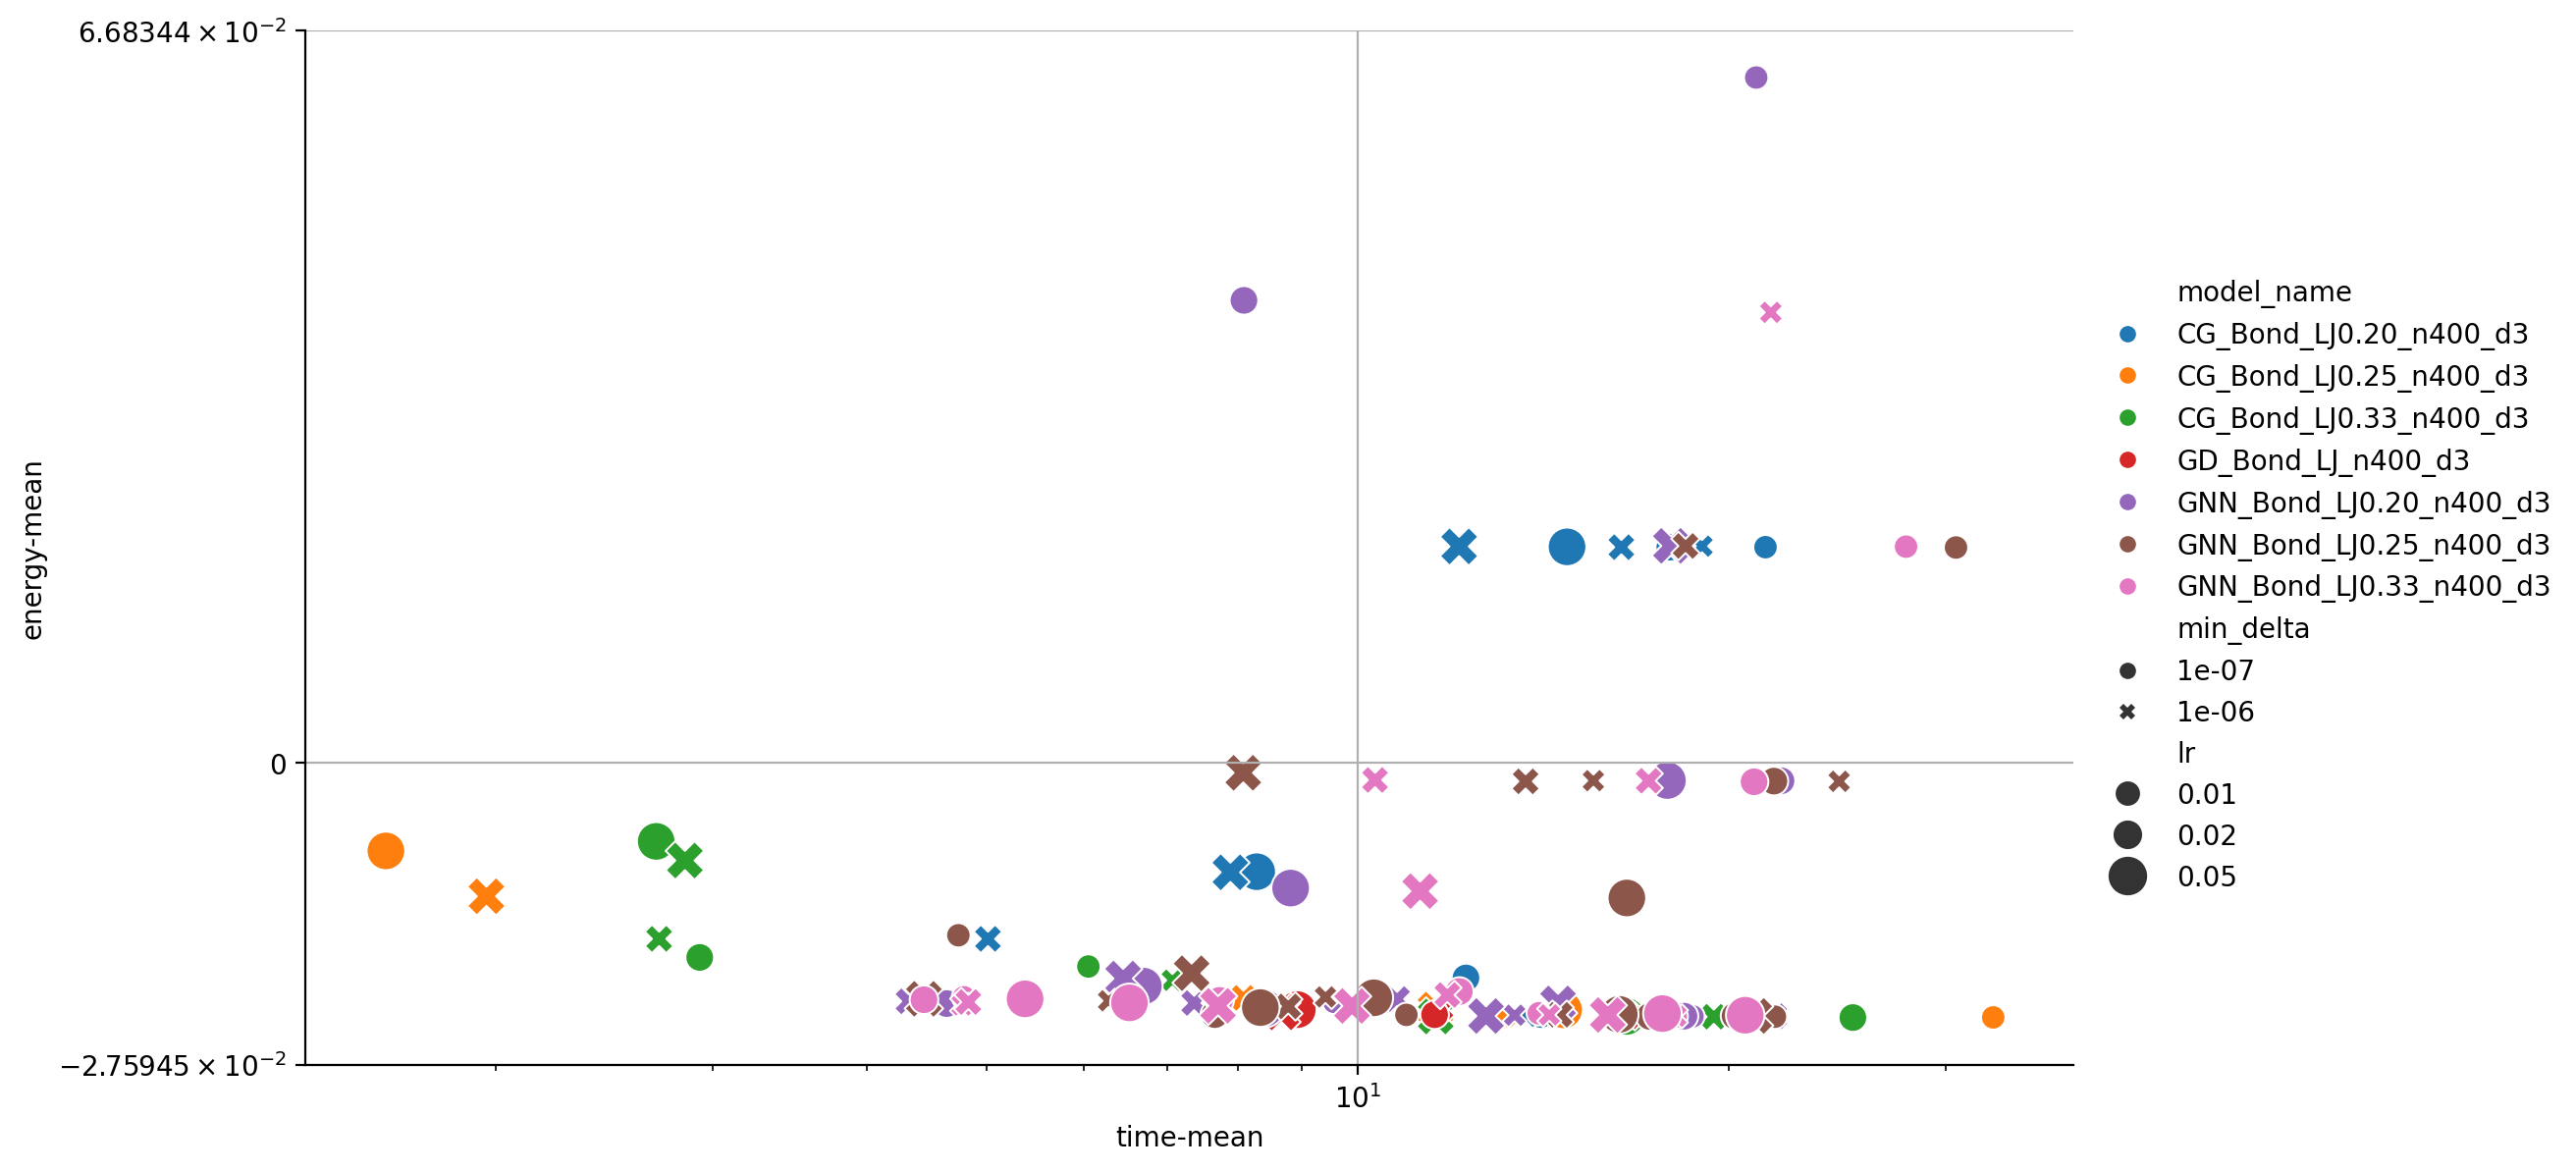

In [105]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

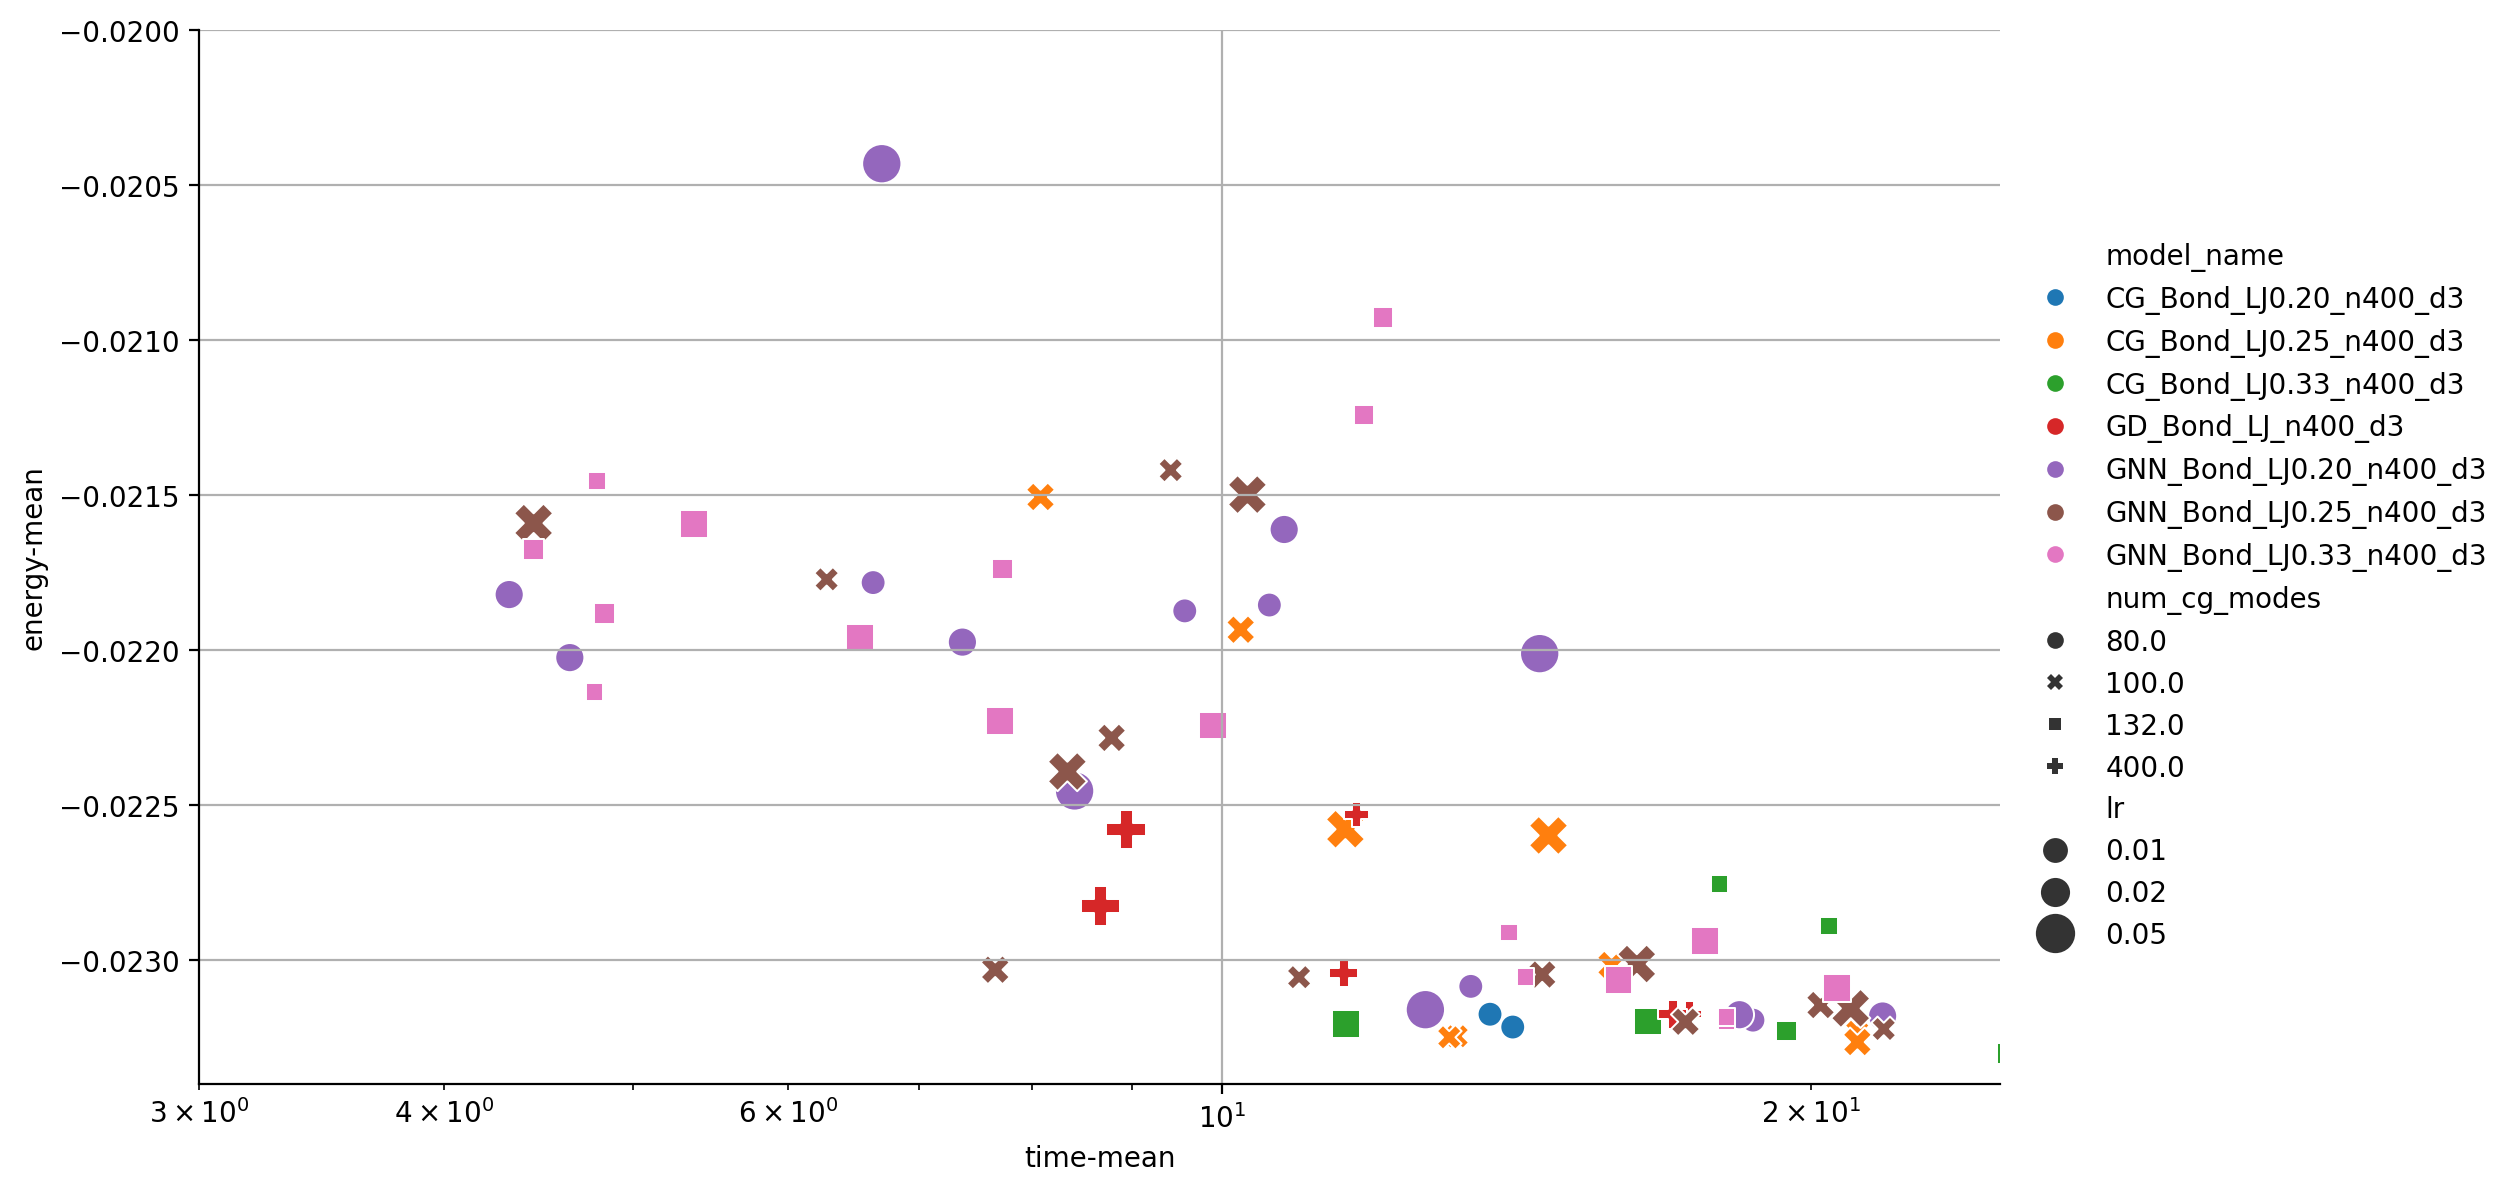

In [107]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.020)
plt.xlim(3,25)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

In [108]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [109]:
df_cleaned

,index,model_name,lr,min_delta,num_cg_modes,lr_cg,hidden_dims,energy-mean,energy-std,time-mean,time-std,energy_mean,energy_std,time_mean,time_std
0,0,CG,0.01,1.000000e-07,80.0,0.010,NaN,0.019654,NaN,21.414942,NaN,0.019654,NaN,21.414942,NaN
1,1,CG,0.01,1.000000e-07,80.0,0.100,NaN,-0.023218,NaN,14.081982,NaN,-0.023218,NaN,14.081982,NaN
2,2,CG,0.01,1.000000e-06,80.0,0.010,NaN,0.019747,NaN,19.020253,NaN,0.019747,NaN,19.020253,NaN
3,3,CG,0.01,1.000000e-06,80.0,0.100,NaN,-0.023176,NaN,13.710245,NaN,-0.023176,NaN,13.710245,NaN
4,4,CG,0.02,1.000000e-07,80.0,0.020,NaN,0.019654,NaN,17.910306,NaN,0.019654,NaN,17.910306,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,109,GNN,0.05,1.000000e-07,132.0,0.050,"[8, 4, 3]",-0.023091,0.000109,20.618664,1.584142,-0.023091,0.000109,20.618664,1.584142
110,110,GNN,0.05,1.000000e-06,132.0,0.005,"[32, 16, 3]",-0.022245,0.001294,9.892986,4.355049,-0.022245,0.001294,9.892986,4.355049
111,111,GNN,0.05,1.000000e-06,132.0,0.005,"[8, 4, 3]",-0.023066,0.000005,15.950243,1.601783,-0.023066,0.000005,15.950243,1.601783
112,112,GNN,0.05,1.000000e-06,132.0,0.050,"[32, 16, 3]",-0.022229,0.001267,7.703062,2.890561,-0.022229,0.001267,7.703062,2.890561


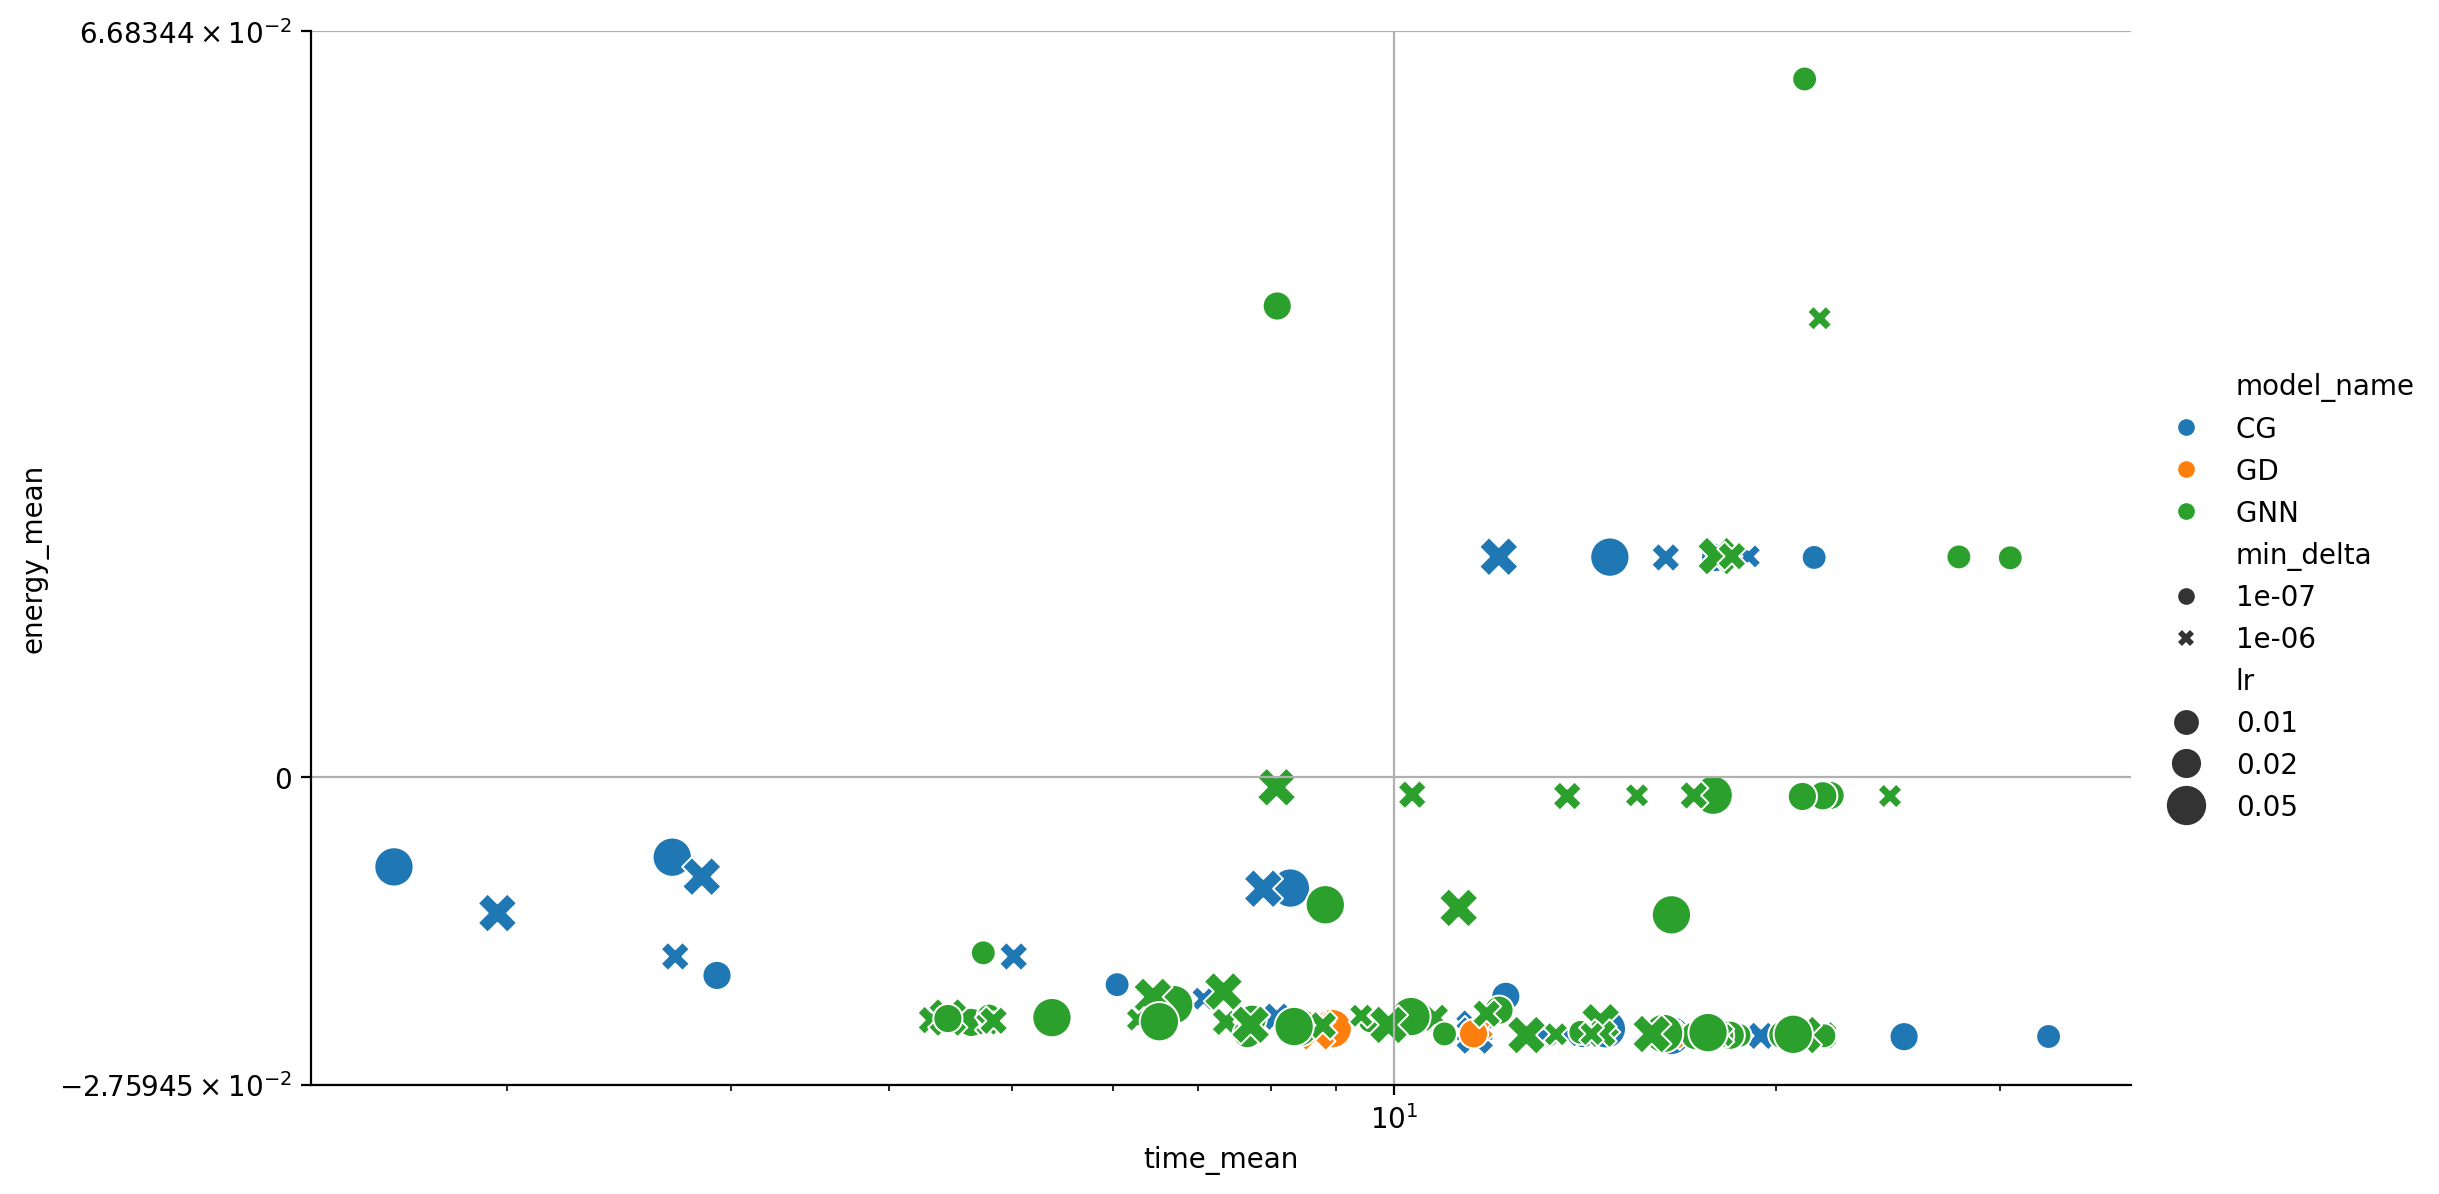

In [110]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

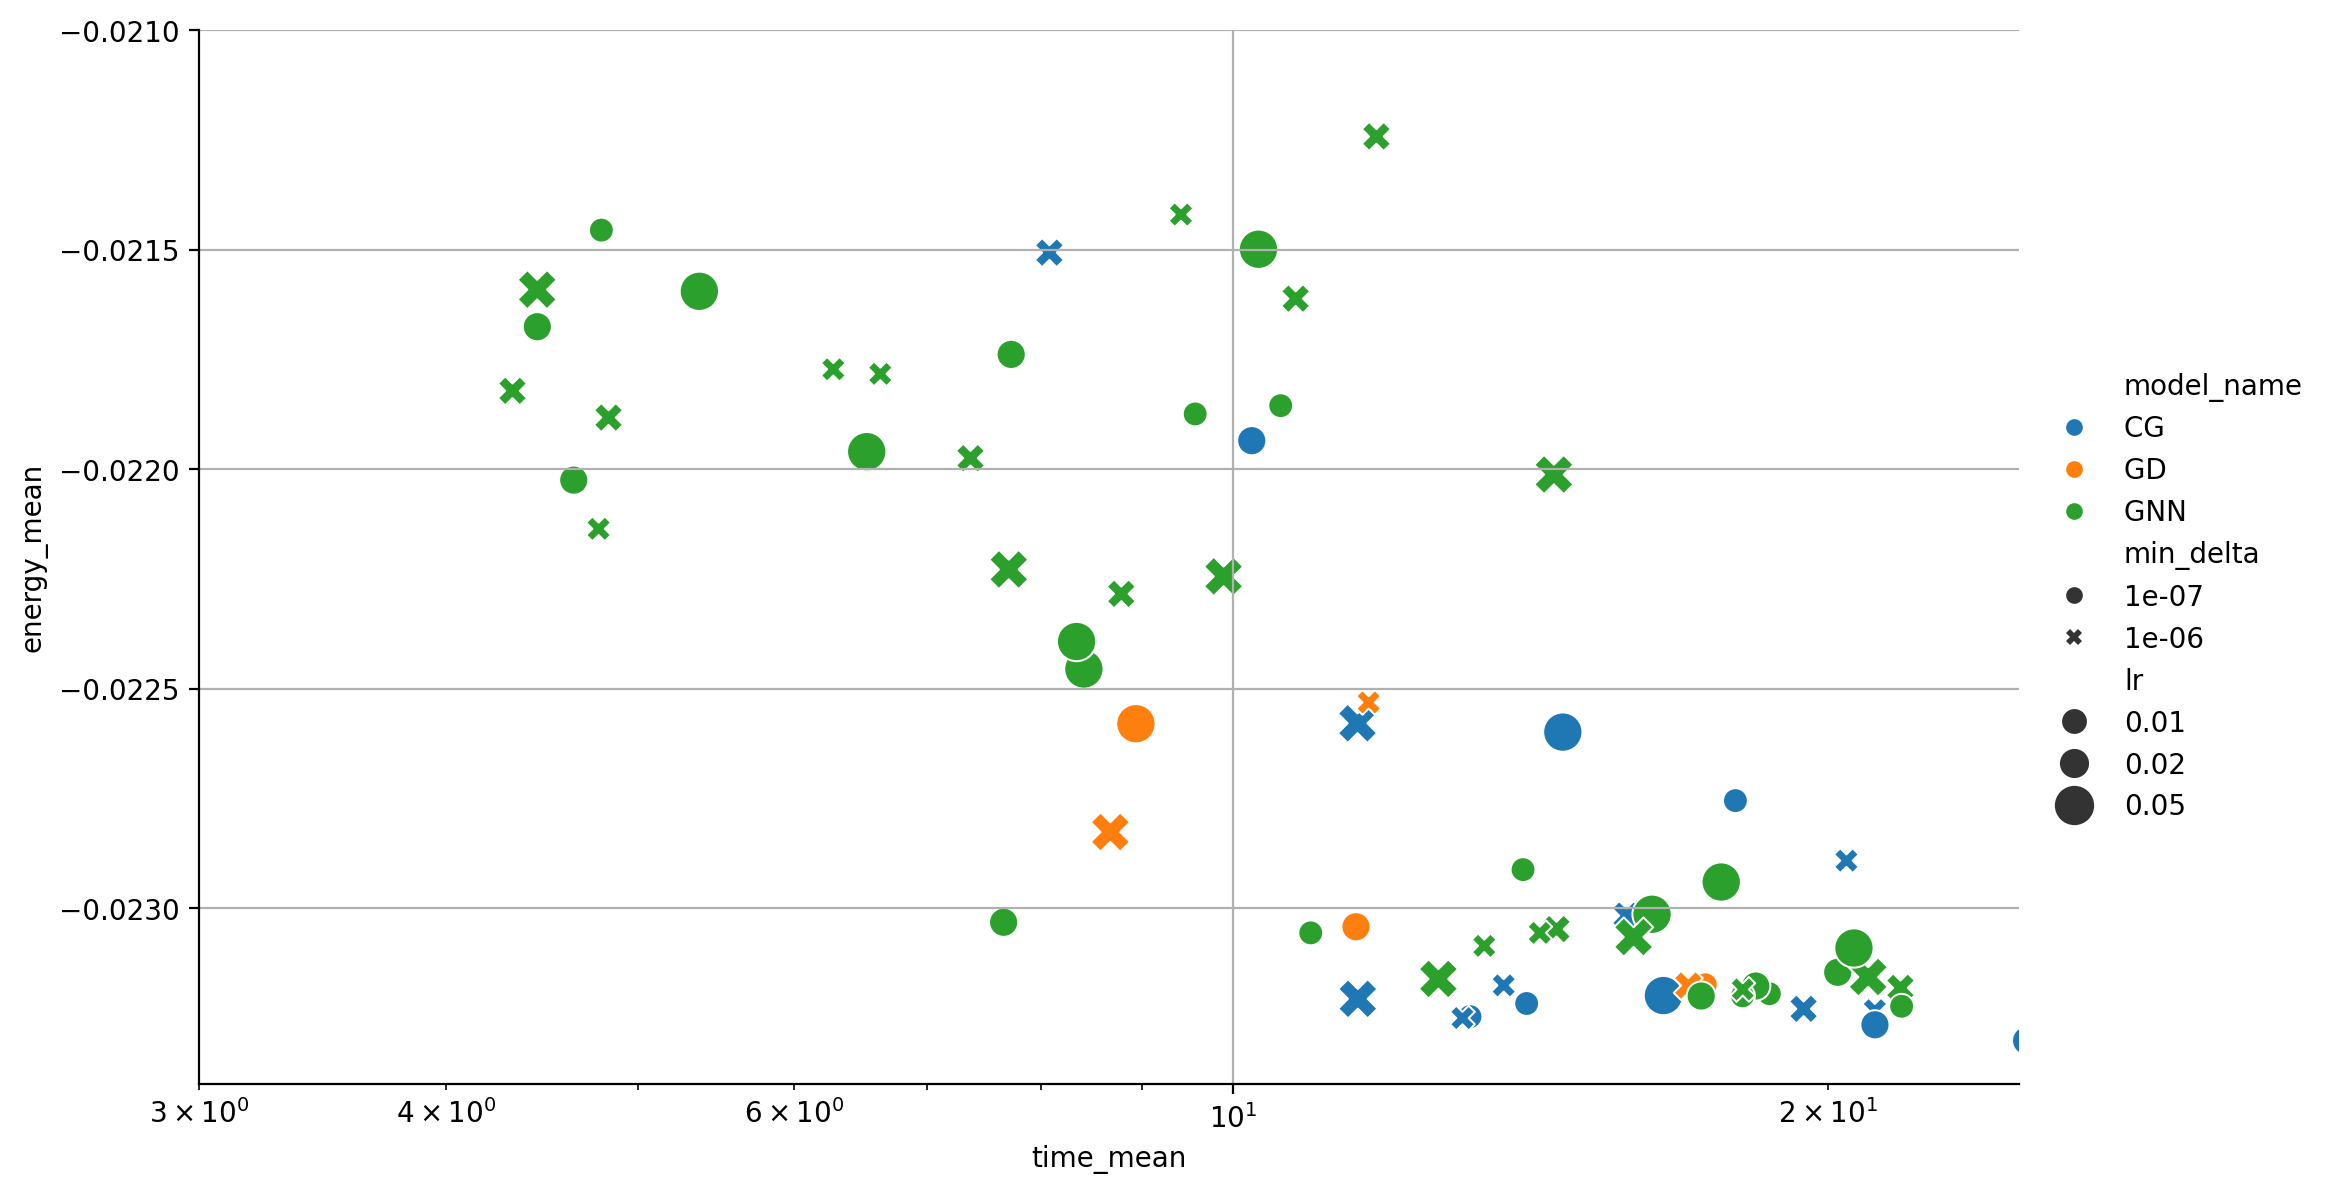

In [111]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.0234, -.0210)
plt.xlim(3,25)
plt.xscale('log')
# plt.yscale('symlog')
plt.grid()

NameError: name 'model_color_dict' is not defined

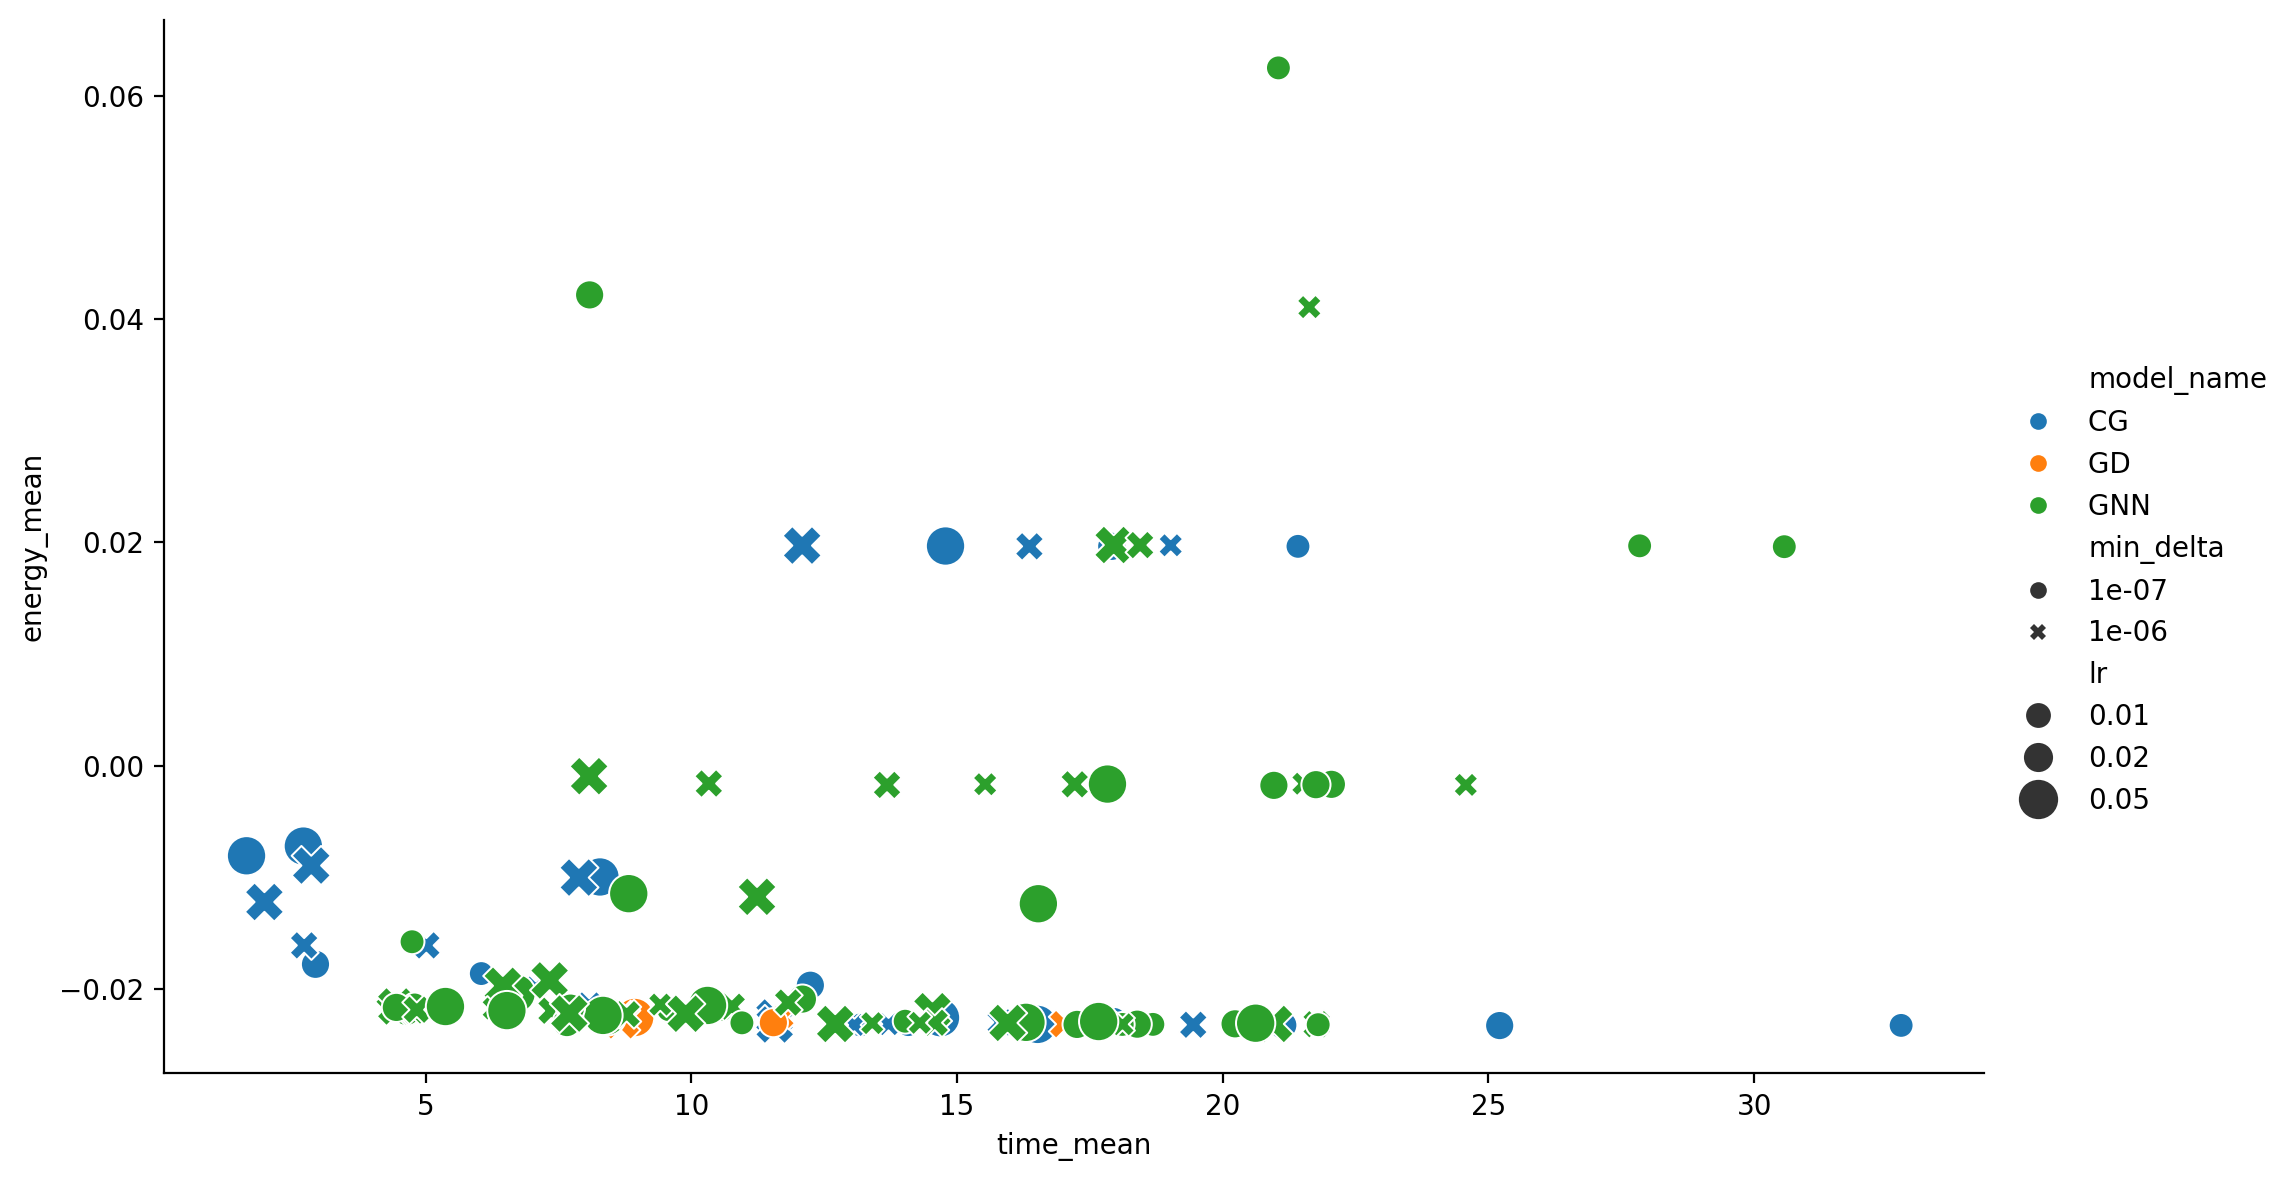

In [112]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

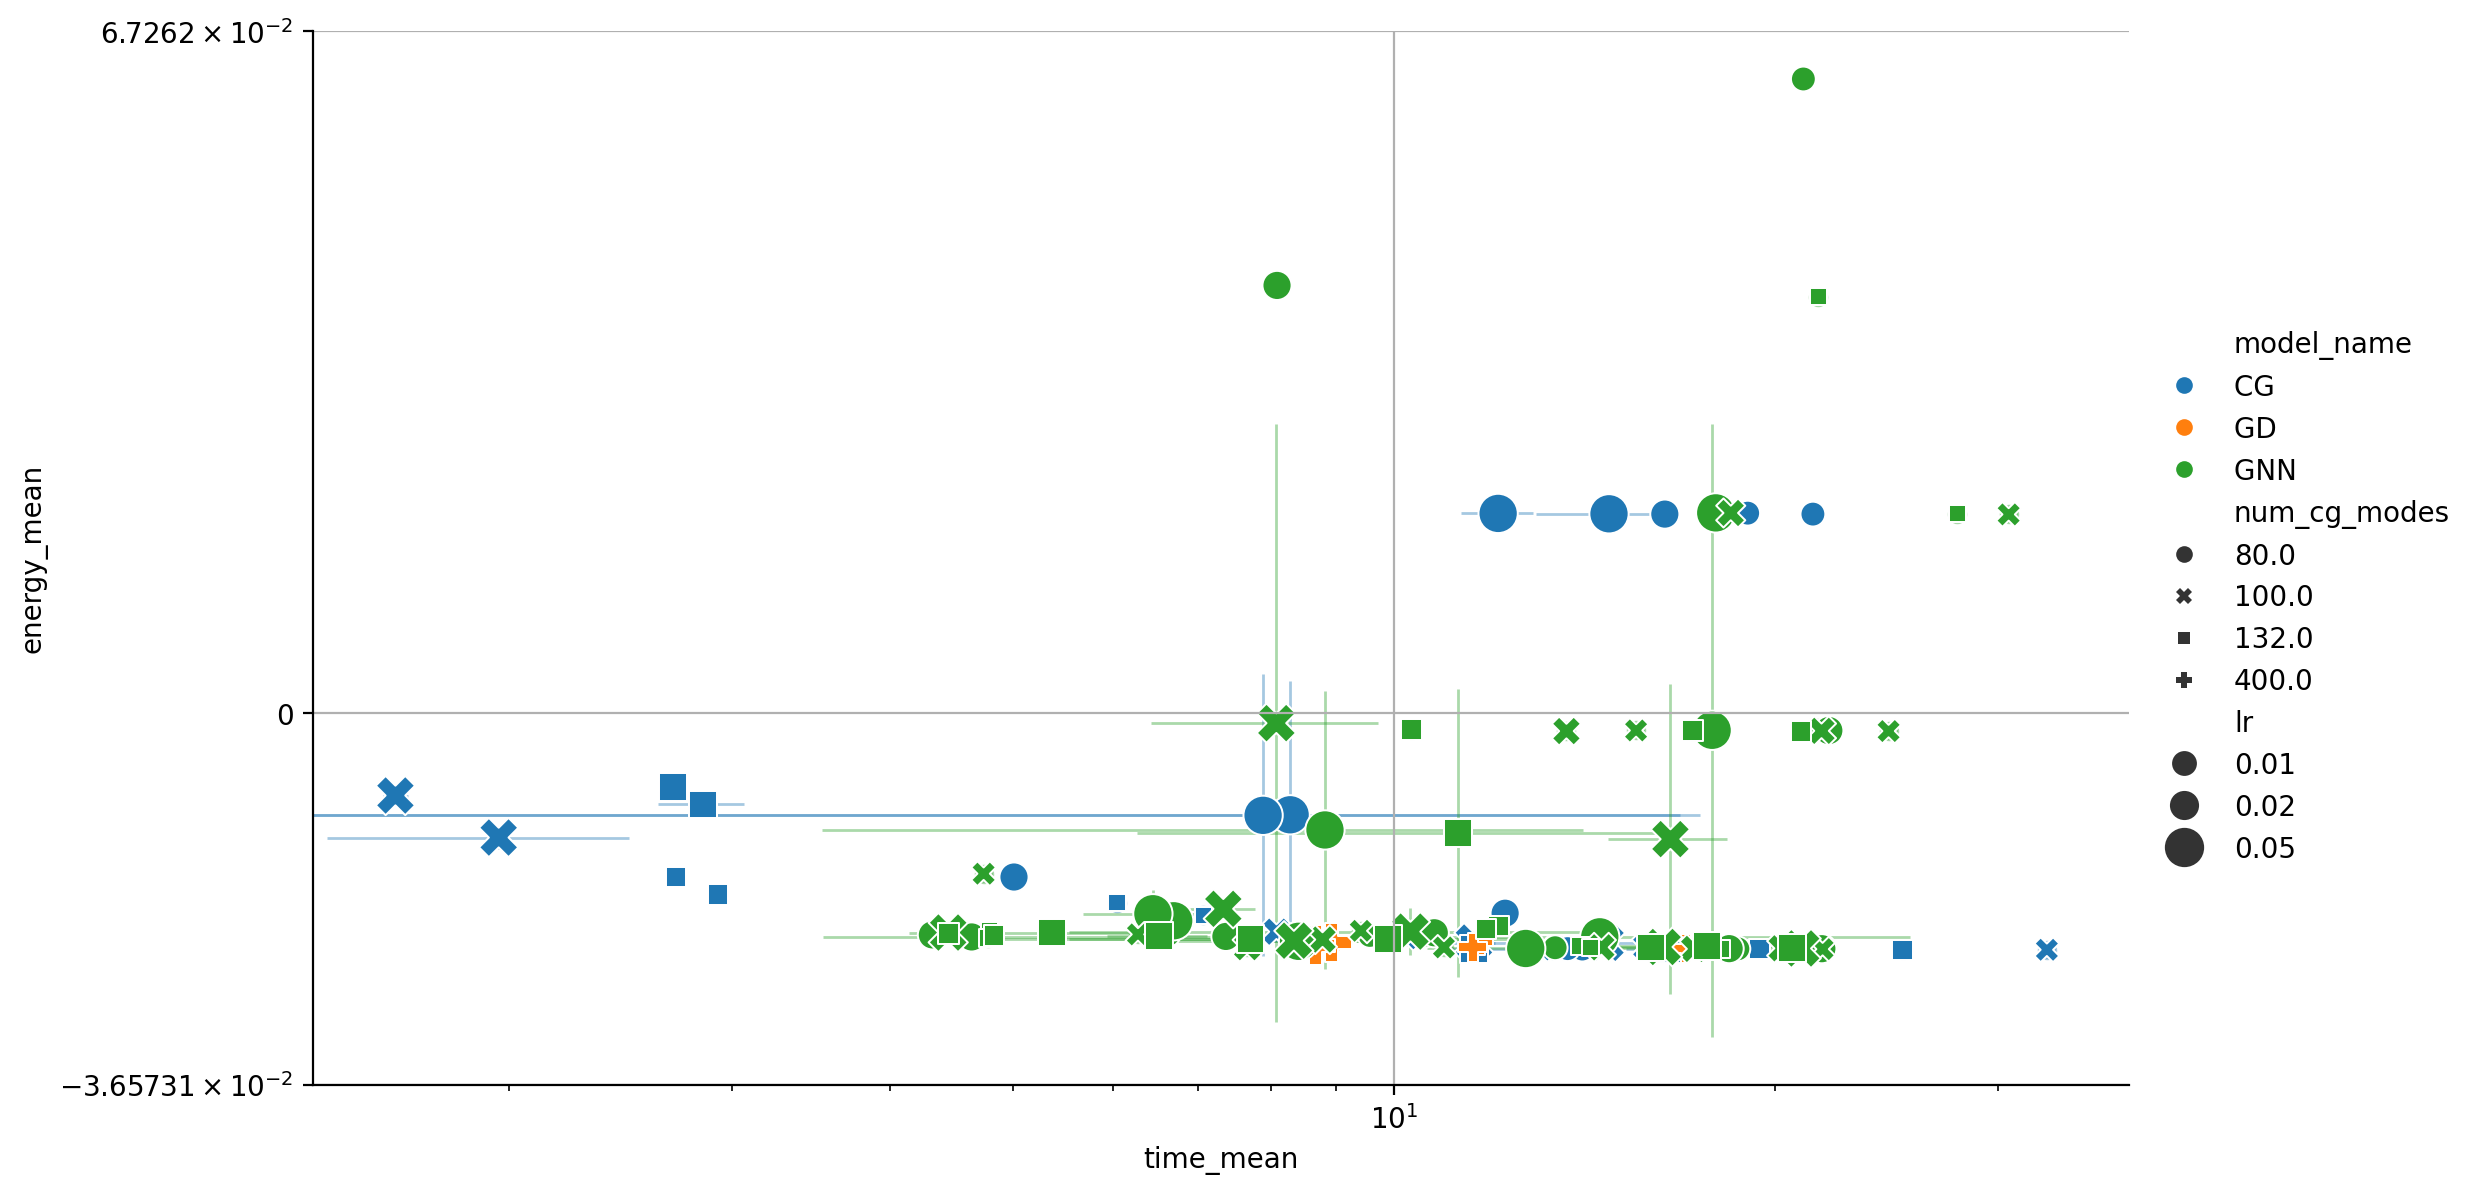

In [115]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))

# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

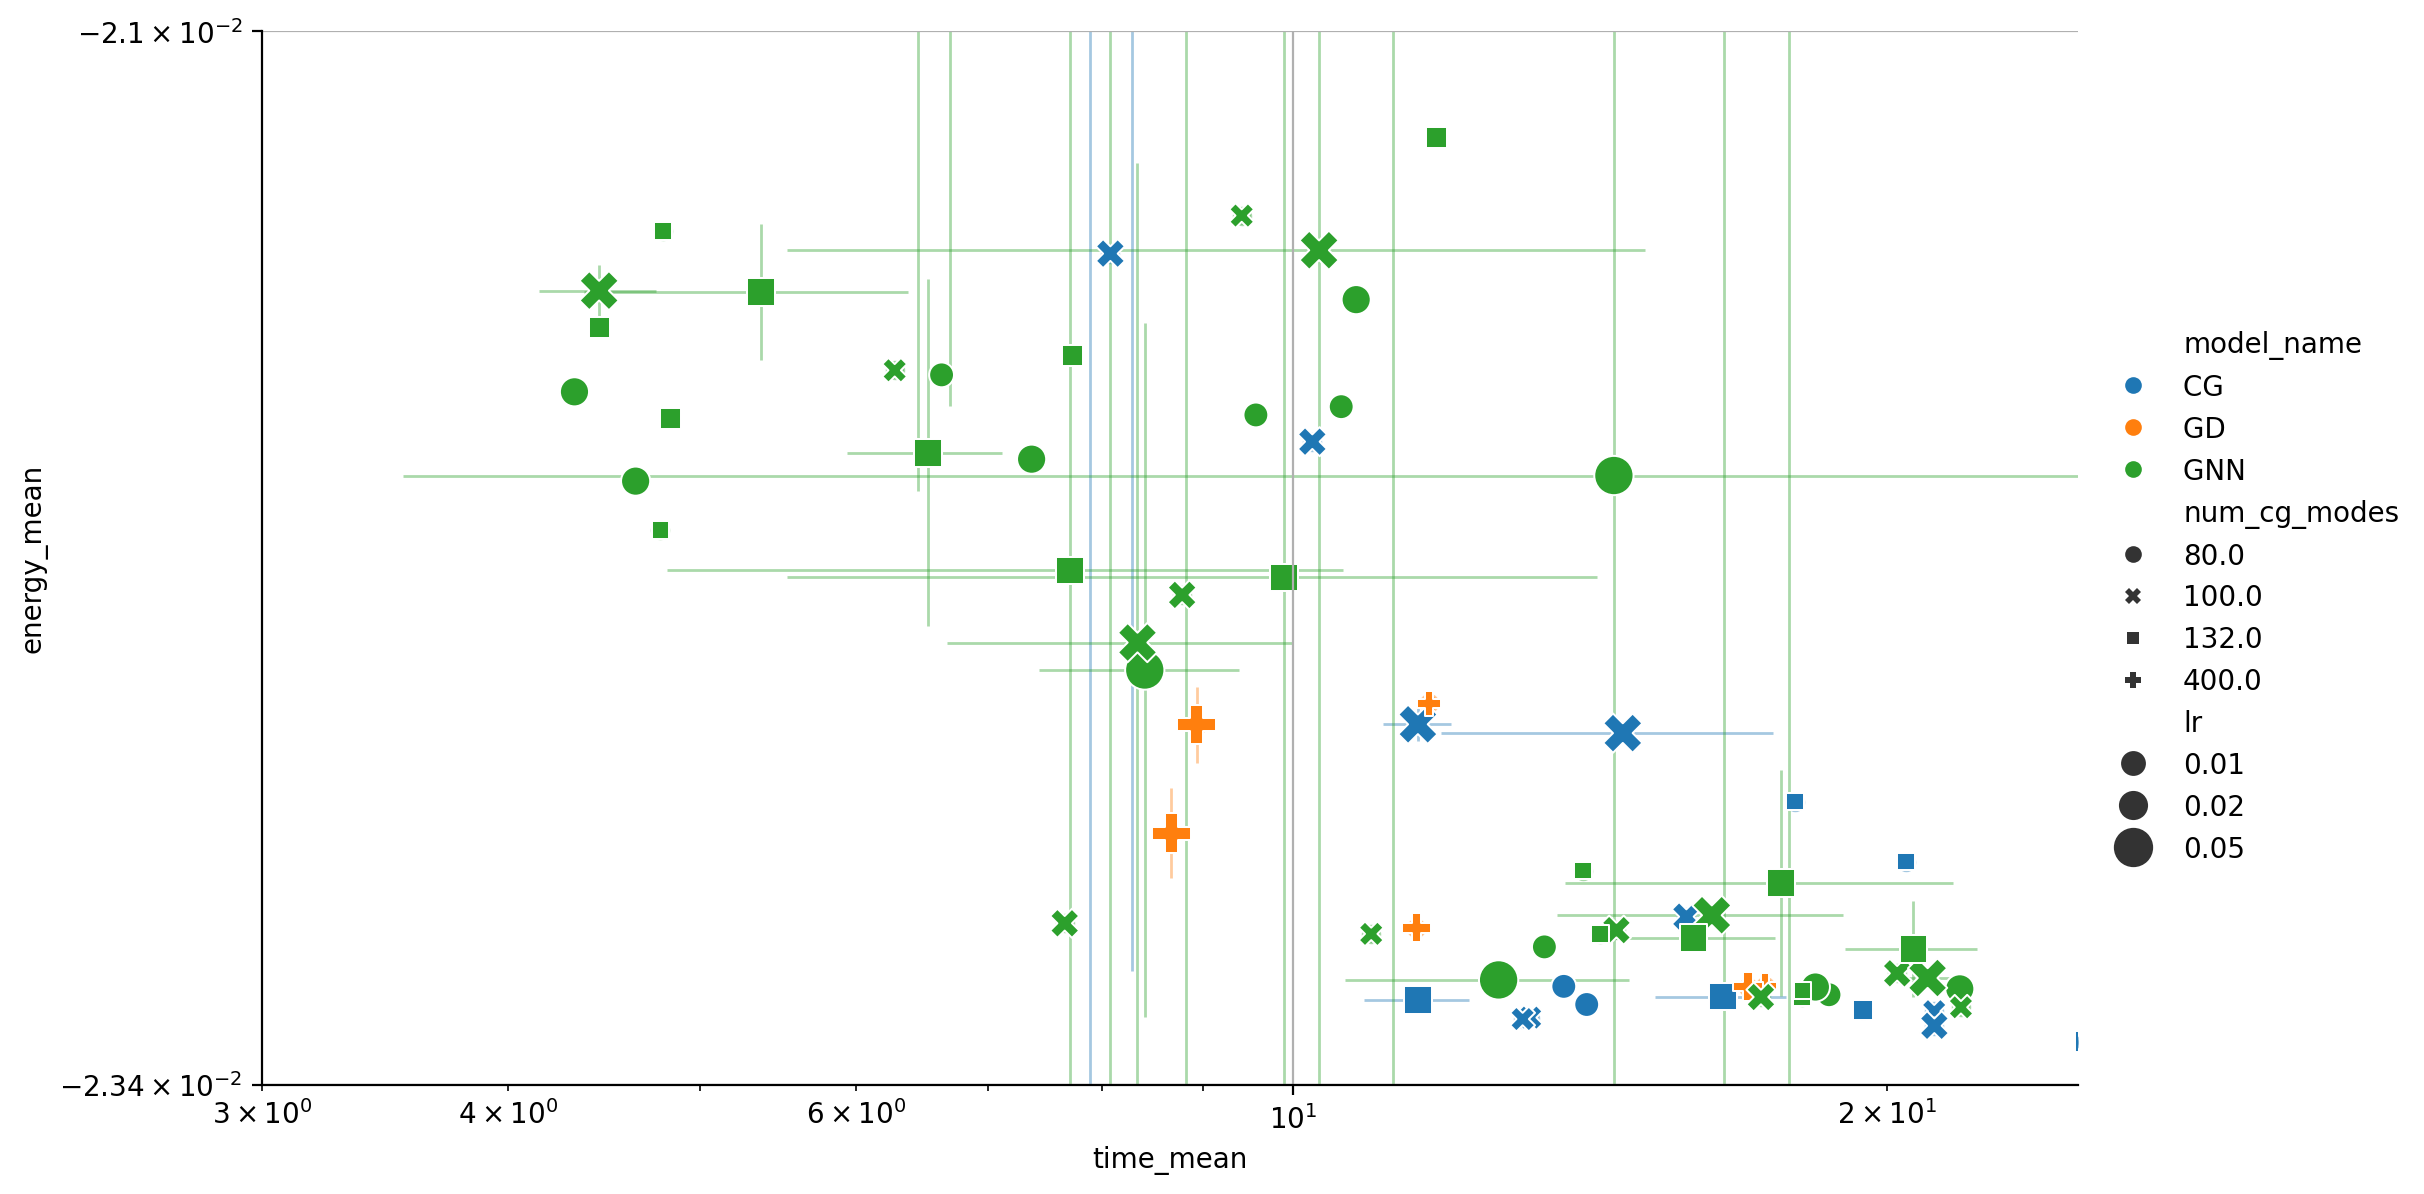

In [116]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# get the map from model names to colors
model_color_dict = dict(zip(model_names, color_palette))
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

plt.ylim(-.0234, -.0210)
plt.xlim(3,25)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

In [89]:
# right before starting the LJ sims
len(df)

174

# LJ double scale loop
Define an energy function which uses LJ with a coupling that has two levels of strength for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

In [1]:
ls results

CG_Bond_LJ_experiment2024-02-09-21.csv
CG_Bond_LJ_experiment2024-02-10-02.csv
CG_Bond_LJ_experiment2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-03.csv
CG_Bond_LJ_experiments2024-02-10-04.csv
CG_Bond_LJ_experiments_2024-02-10-16.csv
CG_LJ2_experiments_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-04.csv
CG_LJ2_experiments_2scale_2024-02-10-05.csv
CG_LJ2_experiments_2scale_2024-02-10-06.csv
logs/
test2024-02-09-22.csv
test2024-02-09-23.csv


In [9]:
# exp_logger = ExperimentLogger(previous_results_csv='./results/CG_LJ2_experiments_2024-02-10-04.csv')
# exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
exp_logger = ExperimentLogger(previous_results_csv='./results/CG_LJ2_experiments_2scale_2024-02-10-06.csv')
df = exp_logger.to_dataframe()

In [13]:
sns.relplot?

Signature:
sns.relplot(
    data=None,
    *,
    x=None,
    y=None,
    hue=None,
    size=None,
    style=None,
    units=None,
    weights=None,
    row=None,
    col=None,
    col_wrap=None,
    row_order=None,
    col_order=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=None,
    dashes=None,
    style_order=None,
    legend='auto',
    kind='scatter',
    height=5,
    aspect=1,
    facet_kws=None,
    **kwargs,
)
Docstring:
Figure-level interface for drawing relational plots onto a FacetGrid.

This function provides access to several different axes-level functions
that show the relationship between two variables with semantic mappings
of subsets. The `kind` parameter selects the underlying axes-level
function to use:

- :func:`scatterplot` (with `kind="scatter"`; the default)
- :func:`lineplot` (with `kind="line"`)

Extra keyword arguments are passed to the underlying function, so you
should re

In [130]:
df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims
0,Energy_LJ_2scale,Bond_LJ_n400_d3,0.247403,1.392278,0.05,0.1,20,1.000000e-06,1.838327,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Energy_LJ_2scale,CG_Bond_LJ0.33_n400_d3,0.727117,9.580374,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,527.0,8.515158,0.749255,NaN,NaN
2,Energy_LJ_2scale,GNN_Bond_LJ0.33_n400_d3,0.327568,10.335653,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,422.0,8.722153,0.328345,133.0,"[8, 4, 3]"
3,Energy_LJ_2scale,GNN_Bond_LJ0.33_n400_d3,-0.053740,3.725070,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,34.0,1.192533,-0.018955,133.0,"[32, 16, 3]"
4,Energy_LJ_2scale,CG_Bond_LJ0.25_n400_d3,0.518101,14.386985,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,822.0,13.196695,0.542127,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Energy_LJ_2scale,GNN_Bond_LJ0.25_n400_d3,0.378161,9.386935,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,220.0,4.761004,0.396002,100.0,"[8, 4, 3]"
566,Energy_LJ_2scale,GNN_Bond_LJ0.25_n400_d3,-0.035773,7.855705,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,26.0,1.015844,-0.003536,100.0,"[32, 16, 3]"
567,Energy_LJ_2scale,CG_Bond_LJ0.20_n400_d3,0.723125,19.358500,0.01,0.1,20,1.000000e-07,1.838327,400,0.100,20.0,0.000001,635.0,10.377081,0.760114,NaN,NaN
568,Energy_LJ_2scale,GNN_Bond_LJ0.20_n400_d3,0.642706,10.697762,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,398.0,8.248155,0.643227,80.0,"[8, 4, 3]"


In [133]:
# seems like the num_cg_modes are not logged correctly for "CG_..." models, and base models do not use cg modes
# fortunately, the CG models mention the ratio of cg modes / num nodes in the model name as CG_Bond_LJ[ratio]_n[nodes]_d3
# so we can extract the ratio from the model name, and use it to calculate the number of cg modes
# we can also calculate the number of nodes from the model name

# first, let's extract the ratio and number of nodes from the model name
df['cg_ratio'] = df['model_name'].apply(lambda x: float((x.split('_LJ')[1].split('_')[0] or '1.0')))
df['num_cg_modes'] = df['cg_ratio'] * df['num_nodes']

In [136]:
df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims,cg_ratio
0,Energy_LJ_2scale,Bond_LJ_n400_d3,0.247403,1.392278,0.05,0.1,20,1.000000e-06,1.838327,400,NaN,NaN,NaN,NaN,NaN,NaN,400.0,NaN,1.00
1,Energy_LJ_2scale,CG_Bond_LJ0.33_n400_d3,0.727117,9.580374,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,527.0,8.515158,0.749255,132.0,NaN,0.33
2,Energy_LJ_2scale,GNN_Bond_LJ0.33_n400_d3,0.327568,10.335653,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,422.0,8.722153,0.328345,132.0,"[8, 4, 3]",0.33
3,Energy_LJ_2scale,GNN_Bond_LJ0.33_n400_d3,-0.053740,3.725070,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,34.0,1.192533,-0.018955,132.0,"[32, 16, 3]",0.33
4,Energy_LJ_2scale,CG_Bond_LJ0.25_n400_d3,0.518101,14.386985,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,822.0,13.196695,0.542127,100.0,NaN,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Energy_LJ_2scale,GNN_Bond_LJ0.25_n400_d3,0.378161,9.386935,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,220.0,4.761004,0.396002,100.0,"[8, 4, 3]",0.25
566,Energy_LJ_2scale,GNN_Bond_LJ0.25_n400_d3,-0.035773,7.855705,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,26.0,1.015844,-0.003536,100.0,"[32, 16, 3]",0.25
567,Energy_LJ_2scale,CG_Bond_LJ0.20_n400_d3,0.723125,19.358500,0.01,0.1,20,1.000000e-07,1.838327,400,0.100,20.0,0.000001,635.0,10.377081,0.760114,80.0,NaN,0.20
568,Energy_LJ_2scale,GNN_Bond_LJ0.20_n400_d3,0.642706,10.697762,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,398.0,8.248155,0.643227,80.0,"[8, 4, 3]",0.20


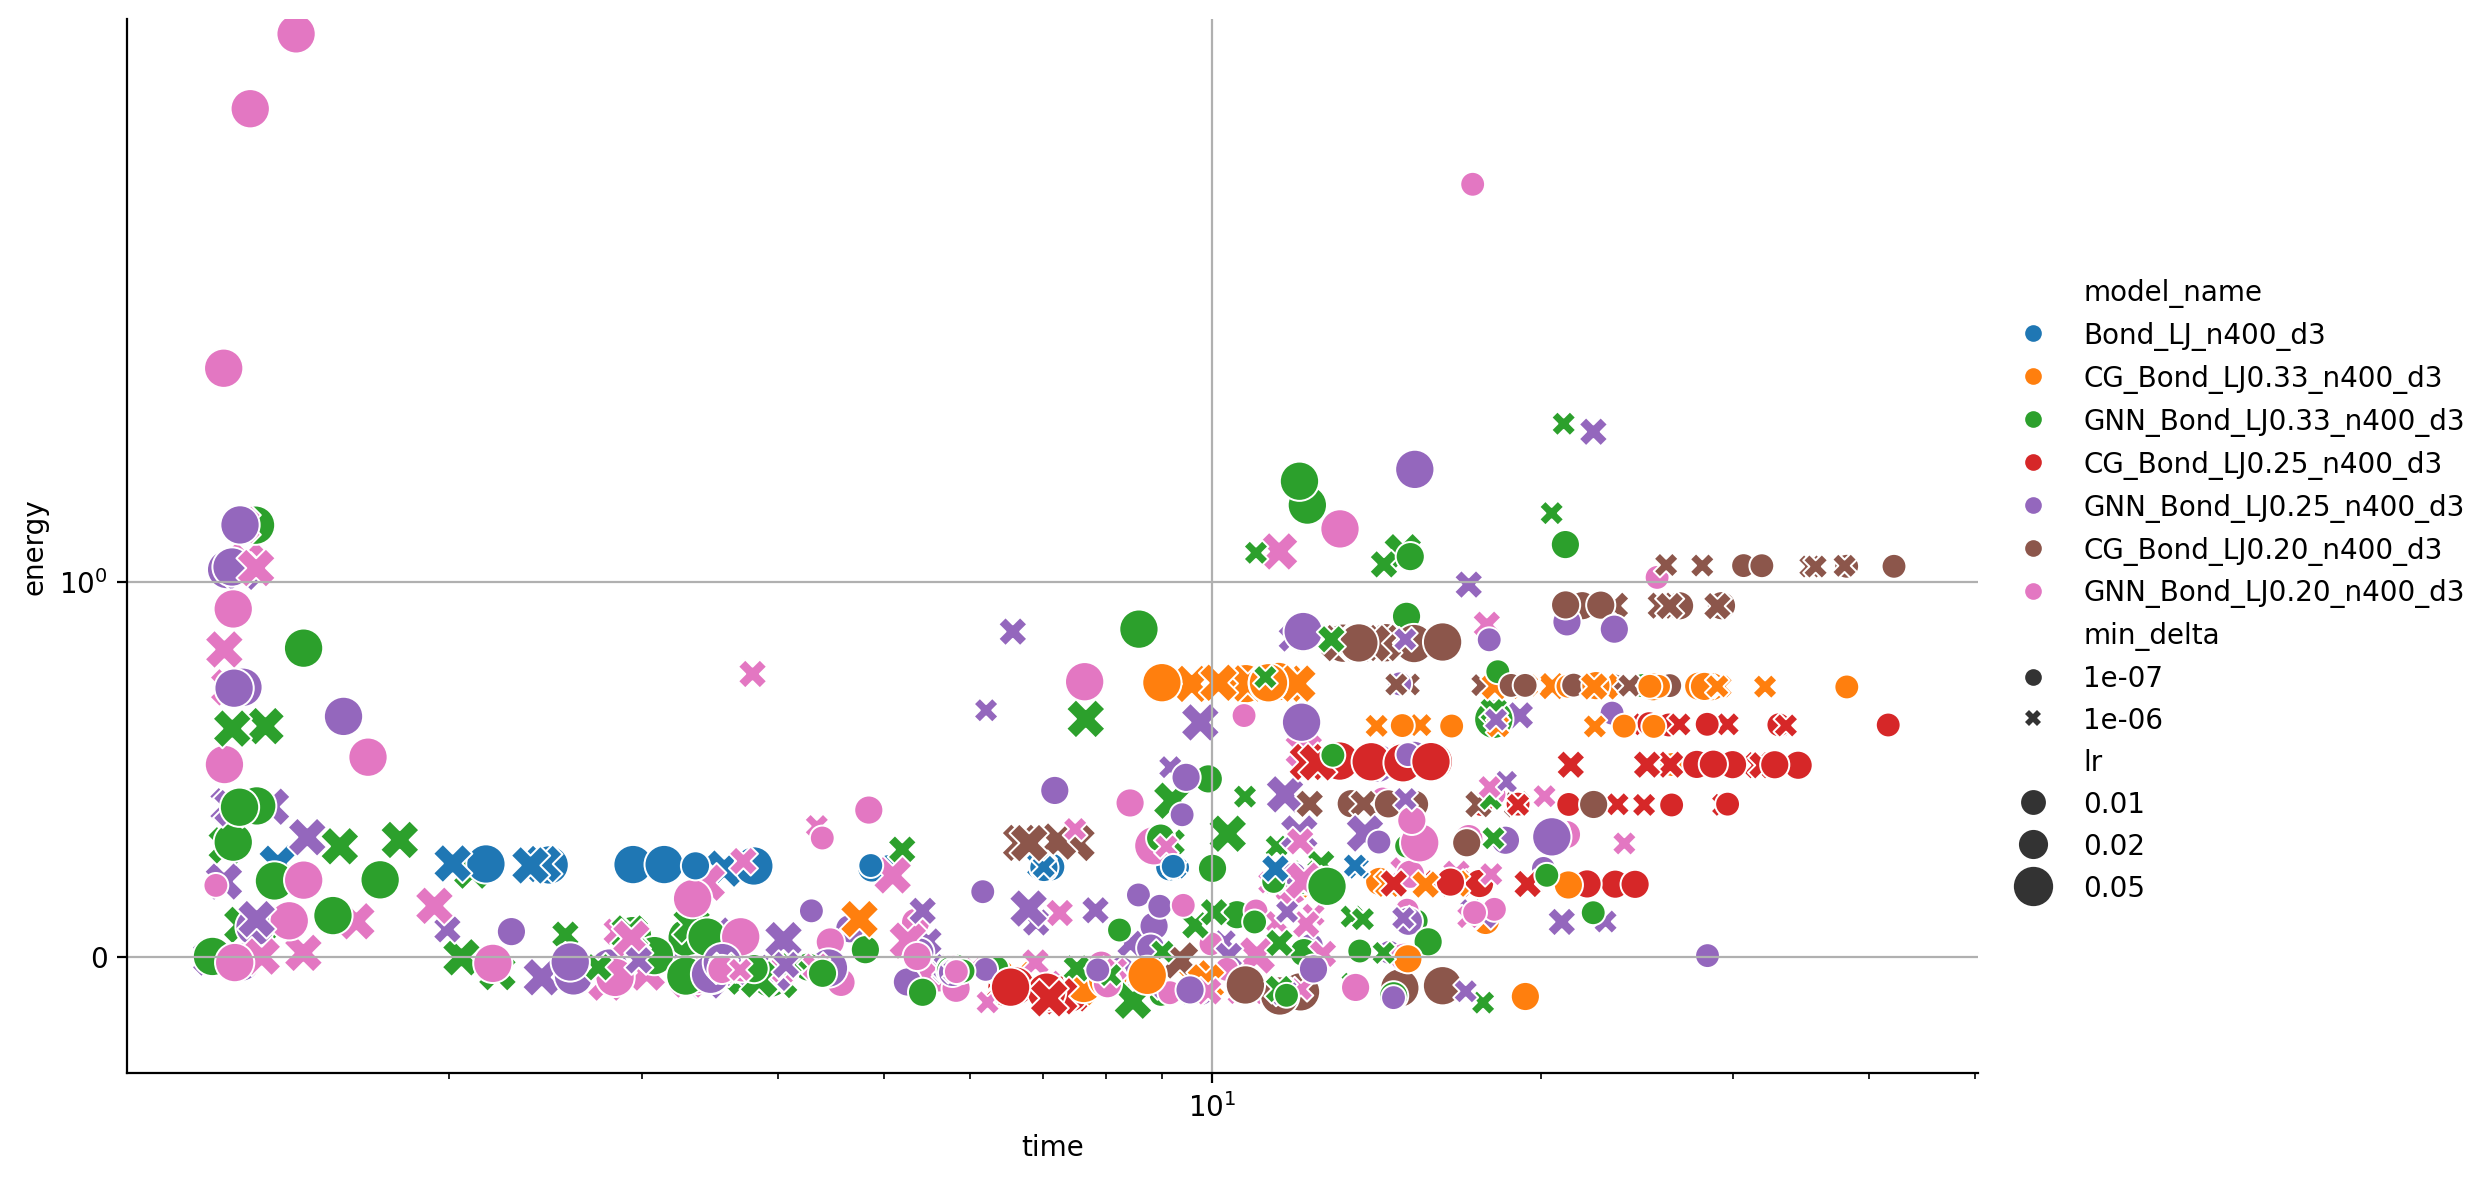

In [137]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

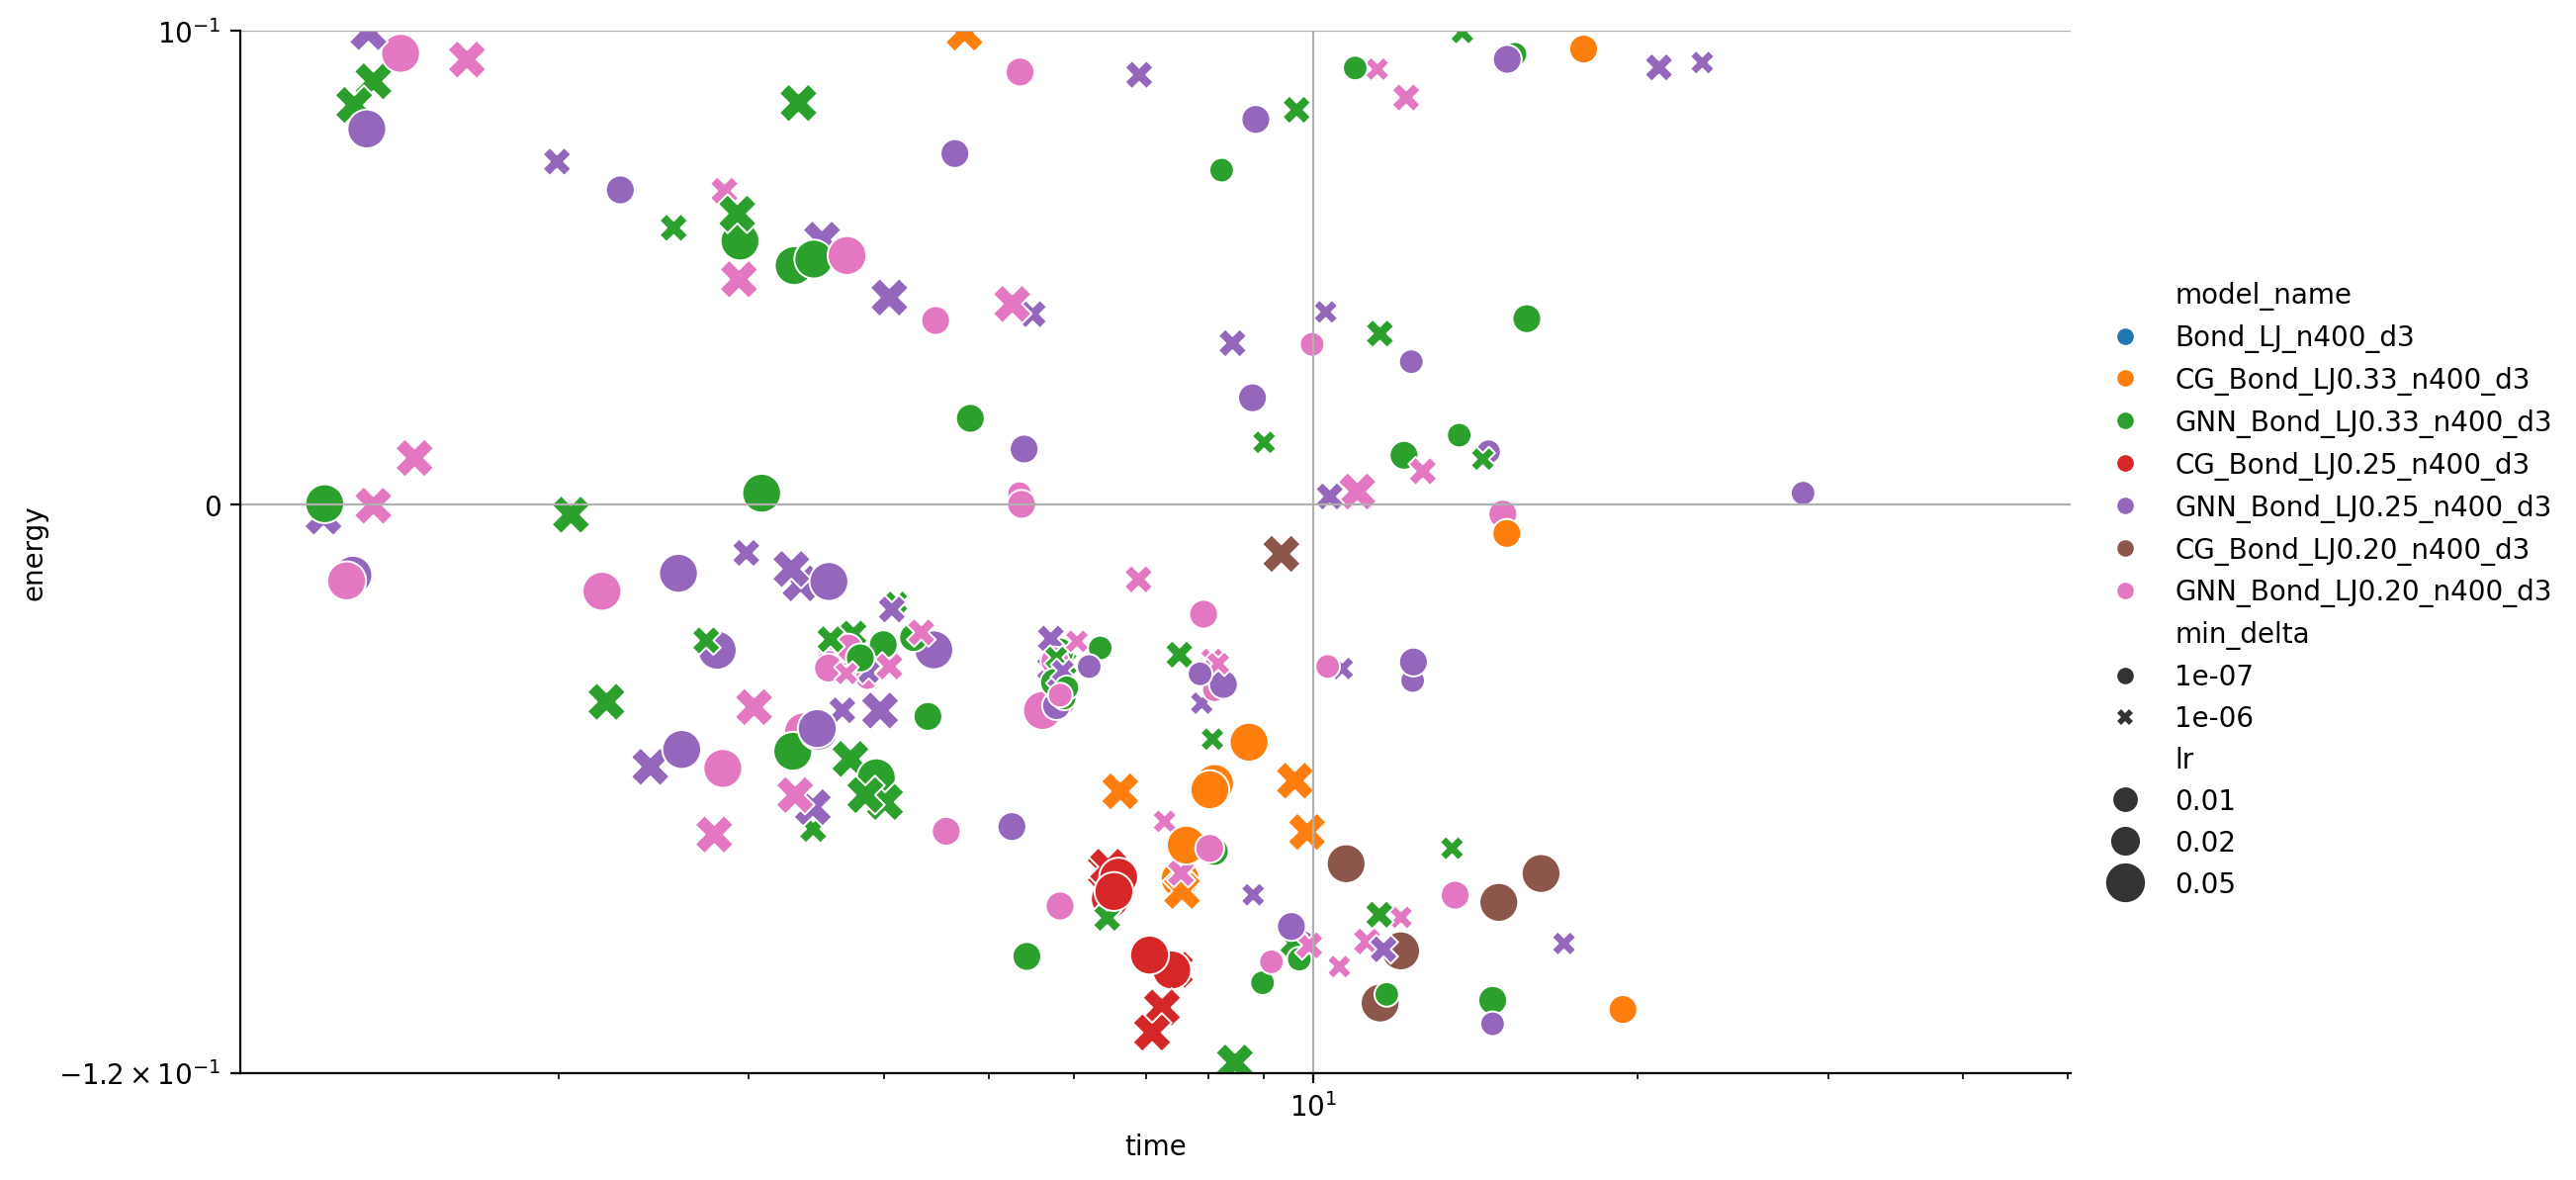

In [139]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

## Grouping similar runs

In [140]:
# We replace the NaN with 0 before applying groupby to avoid losing rows
df_copy = df.copy()
df_copy.fillna('na', inplace=True)
# we will group by the model_name, lr, and min_delta
df_grouped = df_copy.groupby(['model_name', 'lr', 'min_delta', 'num_cg_modes', 'lr_cg', 'hidden_dims'])
# other options: cg_patience,cg_min_delta
# we can now calculate the mean and std of the energy for each group
# only take the mean of the energy and time column (the other columns are not relevant and may contain non-numeric values)
df_mean = df_grouped.agg({'energy': ['mean', 'std'], 'time': ['mean','std']})
df_mean.reset_index(inplace=True)

# now we will revert the 'na' values to NaN
df_mean.replace('na', np.nan, inplace=True)
df_mean

/tmp/ipykernel_1624139/3992581159.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'na' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_copy.fillna('na', inplace=True)
/tmp/ipykernel_1624139/3992581159.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mean.replace('na', np.nan, inplace=True)


model_name    lr     min_delta num_cg_modes  lr_cg  \
                                                                       
0            Bond_LJ_n400_d3  0.01  1.000000e-07        400.0    NaN   
1            Bond_LJ_n400_d3  0.01  1.000000e-06        400.0    NaN   
2            Bond_LJ_n400_d3  0.02  1.000000e-07        400.0    NaN   
3            Bond_LJ_n400_d3  0.02  1.000000e-06        400.0    NaN   
4            Bond_LJ_n400_d3  0.05  1.000000e-07        400.0    NaN   
..                       ...   ...           ...          ...    ...   
109  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-07        132.0  0.050   
110  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
111  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.005   
112  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   
113  GNN_Bond_LJ0.33_n400_d3  0.05  1.000000e-06        132.0  0.050   

     hidden_dims    energy                 time            
                      mean       std       mean       std  
0            NaN  0.239989  0.001858   7.085380  2.150125  
1            NaN  0.239260  0.002345  10.083259  3.301501  
2            NaN  0.238705  0.002149   6.301677  2.231569  
3            NaN  0.241878  0.004612   7.884045  1.981954  
4            NaN  0.244587  0.001987   2.904738  0.634405  
..           ...       ...       ...        ...       ...  
109    [8, 4, 3]  0.103540  0.100937   1.793974  0.745505  
110  [32, 16, 3] -0.031653  0.052676   3.343983  0.757289  
111    [8, 4, 3]  0.467462  0.437481  10.121132  2.875315  
112  [32, 16, 3]  0.379413  0.228405   1.350057  0.138640  
113    [8, 4, 3]  0.142383  0.125467   2.126317  0.738173  

[114 rows x 10 columns]

In [143]:
# plot the filtered dataframe using sns directly on df_mean
# note that now we have the mean and std of the energy for each group
# we can use the std to plot the error bars
# we can also use the std to filter the data
# we will create a new column for the error bars
df_mean['energy_mean'] = df_mean['energy']['mean']
df_mean['energy_std'] = df_mean['energy']['std']
# same for time 
df_mean['time_mean'] = df_mean['time']['mean']
df_mean['time_std'] = df_mean['time']['std']
# we will use the mean of the std to filter the data
std_threshold = df_mean['energy']['std'].mean()
# we will filter the data using the std
df_filtered = df_mean[df_mean['energy']['std'] < std_threshold]
df_filtered.reset_index(inplace=True)

df_filtered.columns = [('-'.join(col).strip() if col[1]!='' else col[0]) for col in df_filtered.columns.values]

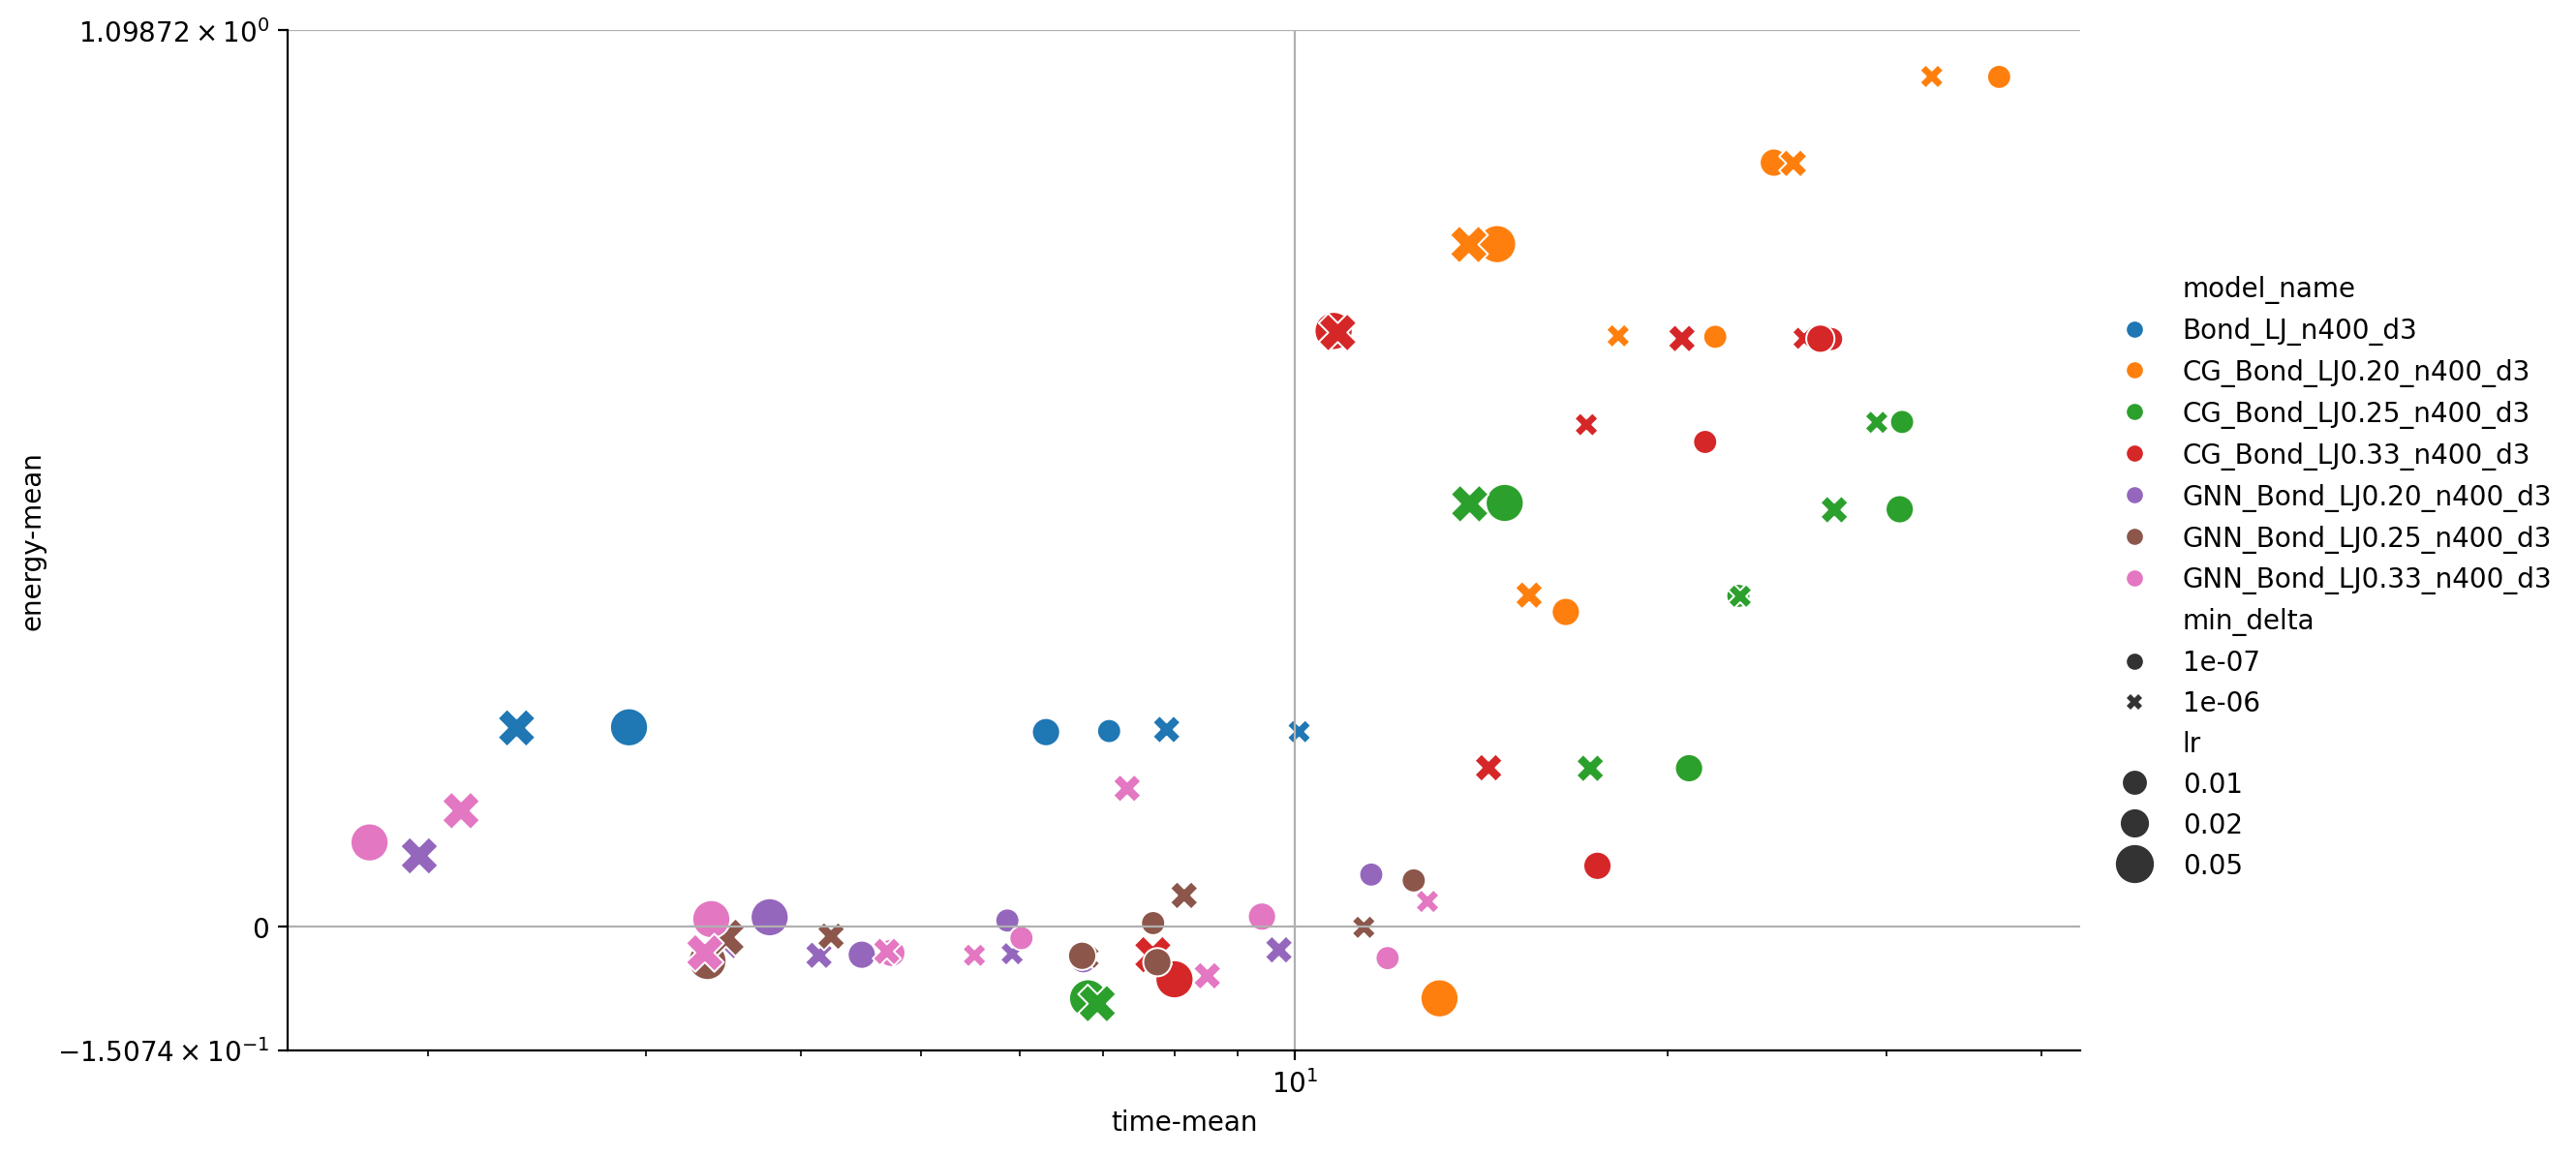

In [144]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

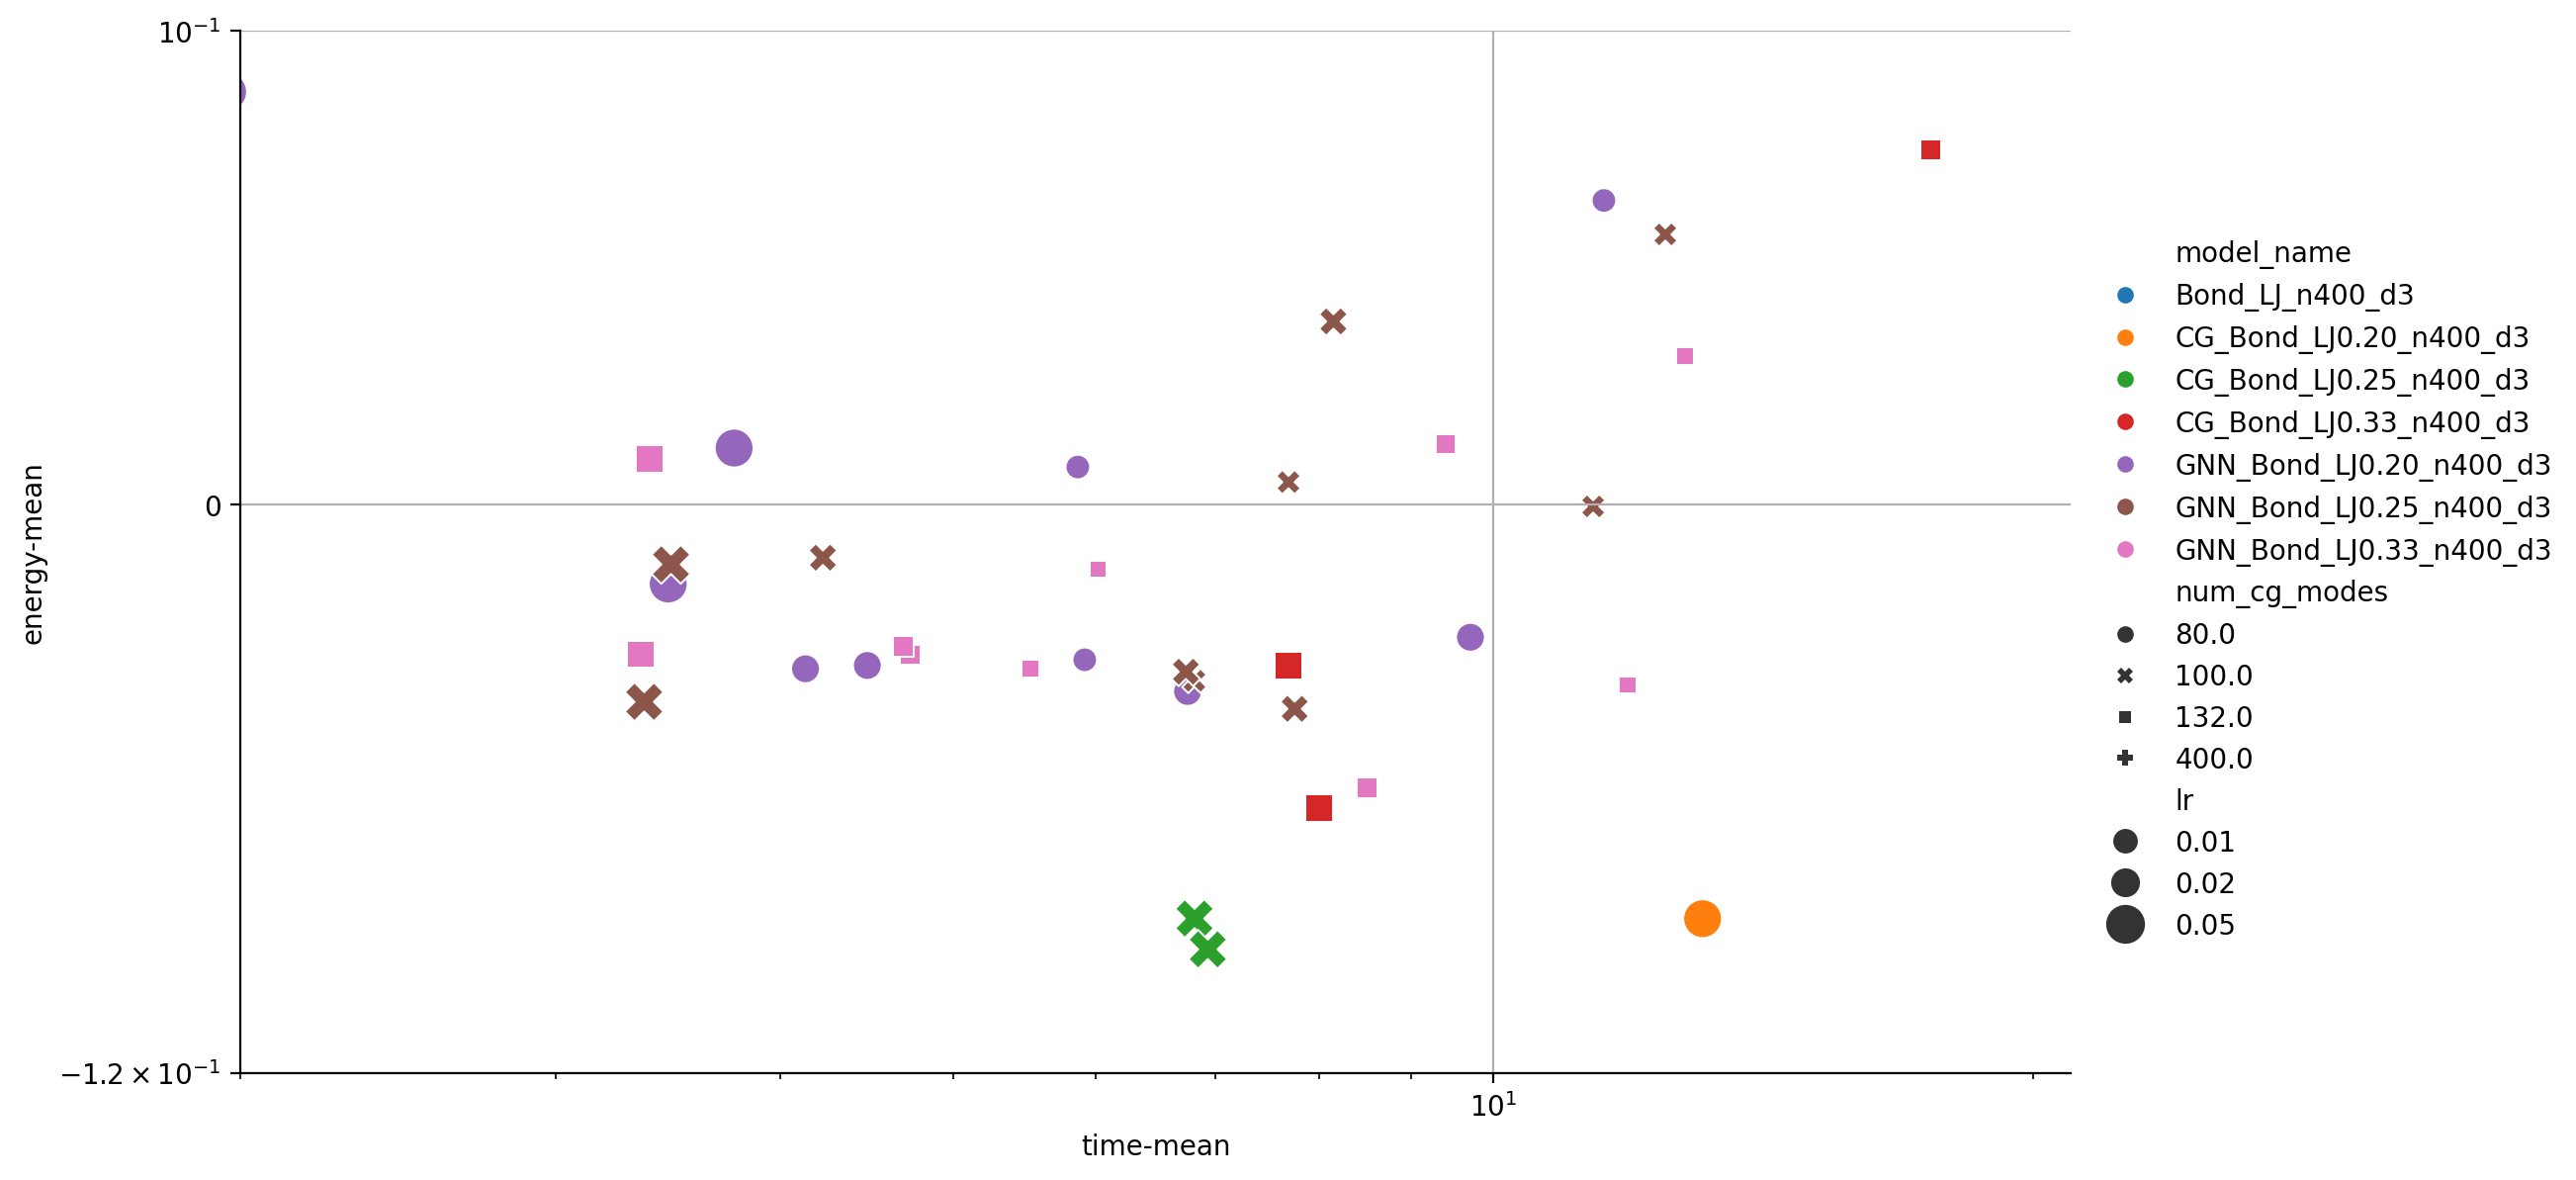

In [145]:
# Flatten the column names

# Now plot with the flattened column names
sns.relplot(data=df_filtered, x='time-mean', y='energy-mean', hue='model_name',style='num_cg_modes', size='lr',
            kind='scatter', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
plt.xlim(2,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

In [146]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df_filtered.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [147]:
df_cleaned

,index,model_name,lr,min_delta,num_cg_modes,lr_cg,hidden_dims,energy-mean,energy-std,time-mean,time-std,energy_mean,energy_std,time_mean,time_std
0,0,Adam,0.01,1.000000e-07,400.0,NaN,NaN,0.239989,0.001858,7.085380,2.150125,0.239989,0.001858,7.085380,2.150125
1,1,Adam,0.01,1.000000e-06,400.0,NaN,NaN,0.239260,0.002345,10.083259,3.301501,0.239260,0.002345,10.083259,3.301501
2,2,Adam,0.02,1.000000e-07,400.0,NaN,NaN,0.238705,0.002149,6.301677,2.231569,0.238705,0.002149,6.301677,2.231569
3,3,Adam,0.02,1.000000e-06,400.0,NaN,NaN,0.241878,0.004612,7.884045,1.981954,0.241878,0.004612,7.884045,1.981954
4,4,Adam,0.05,1.000000e-07,400.0,NaN,NaN,0.244587,0.001987,2.904738,0.634405,0.244587,0.001987,2.904738,0.634405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,105,GNN,0.02,1.000000e-06,132.0,0.020,"[8, 4, 3]",0.169767,0.116026,7.326153,3.298457,0.169767,0.116026,7.326153,3.298457
70,106,GNN,0.05,1.000000e-07,132.0,0.005,"[32, 16, 3]",0.009590,0.058958,3.384293,0.359979,0.009590,0.058958,3.384293,0.359979
71,109,GNN,0.05,1.000000e-07,132.0,0.050,"[8, 4, 3]",0.103540,0.100937,1.793974,0.745505,0.103540,0.100937,1.793974,0.745505
72,110,GNN,0.05,1.000000e-06,132.0,0.005,"[32, 16, 3]",-0.031653,0.052676,3.343983,0.757289,-0.031653,0.052676,3.343983,0.757289


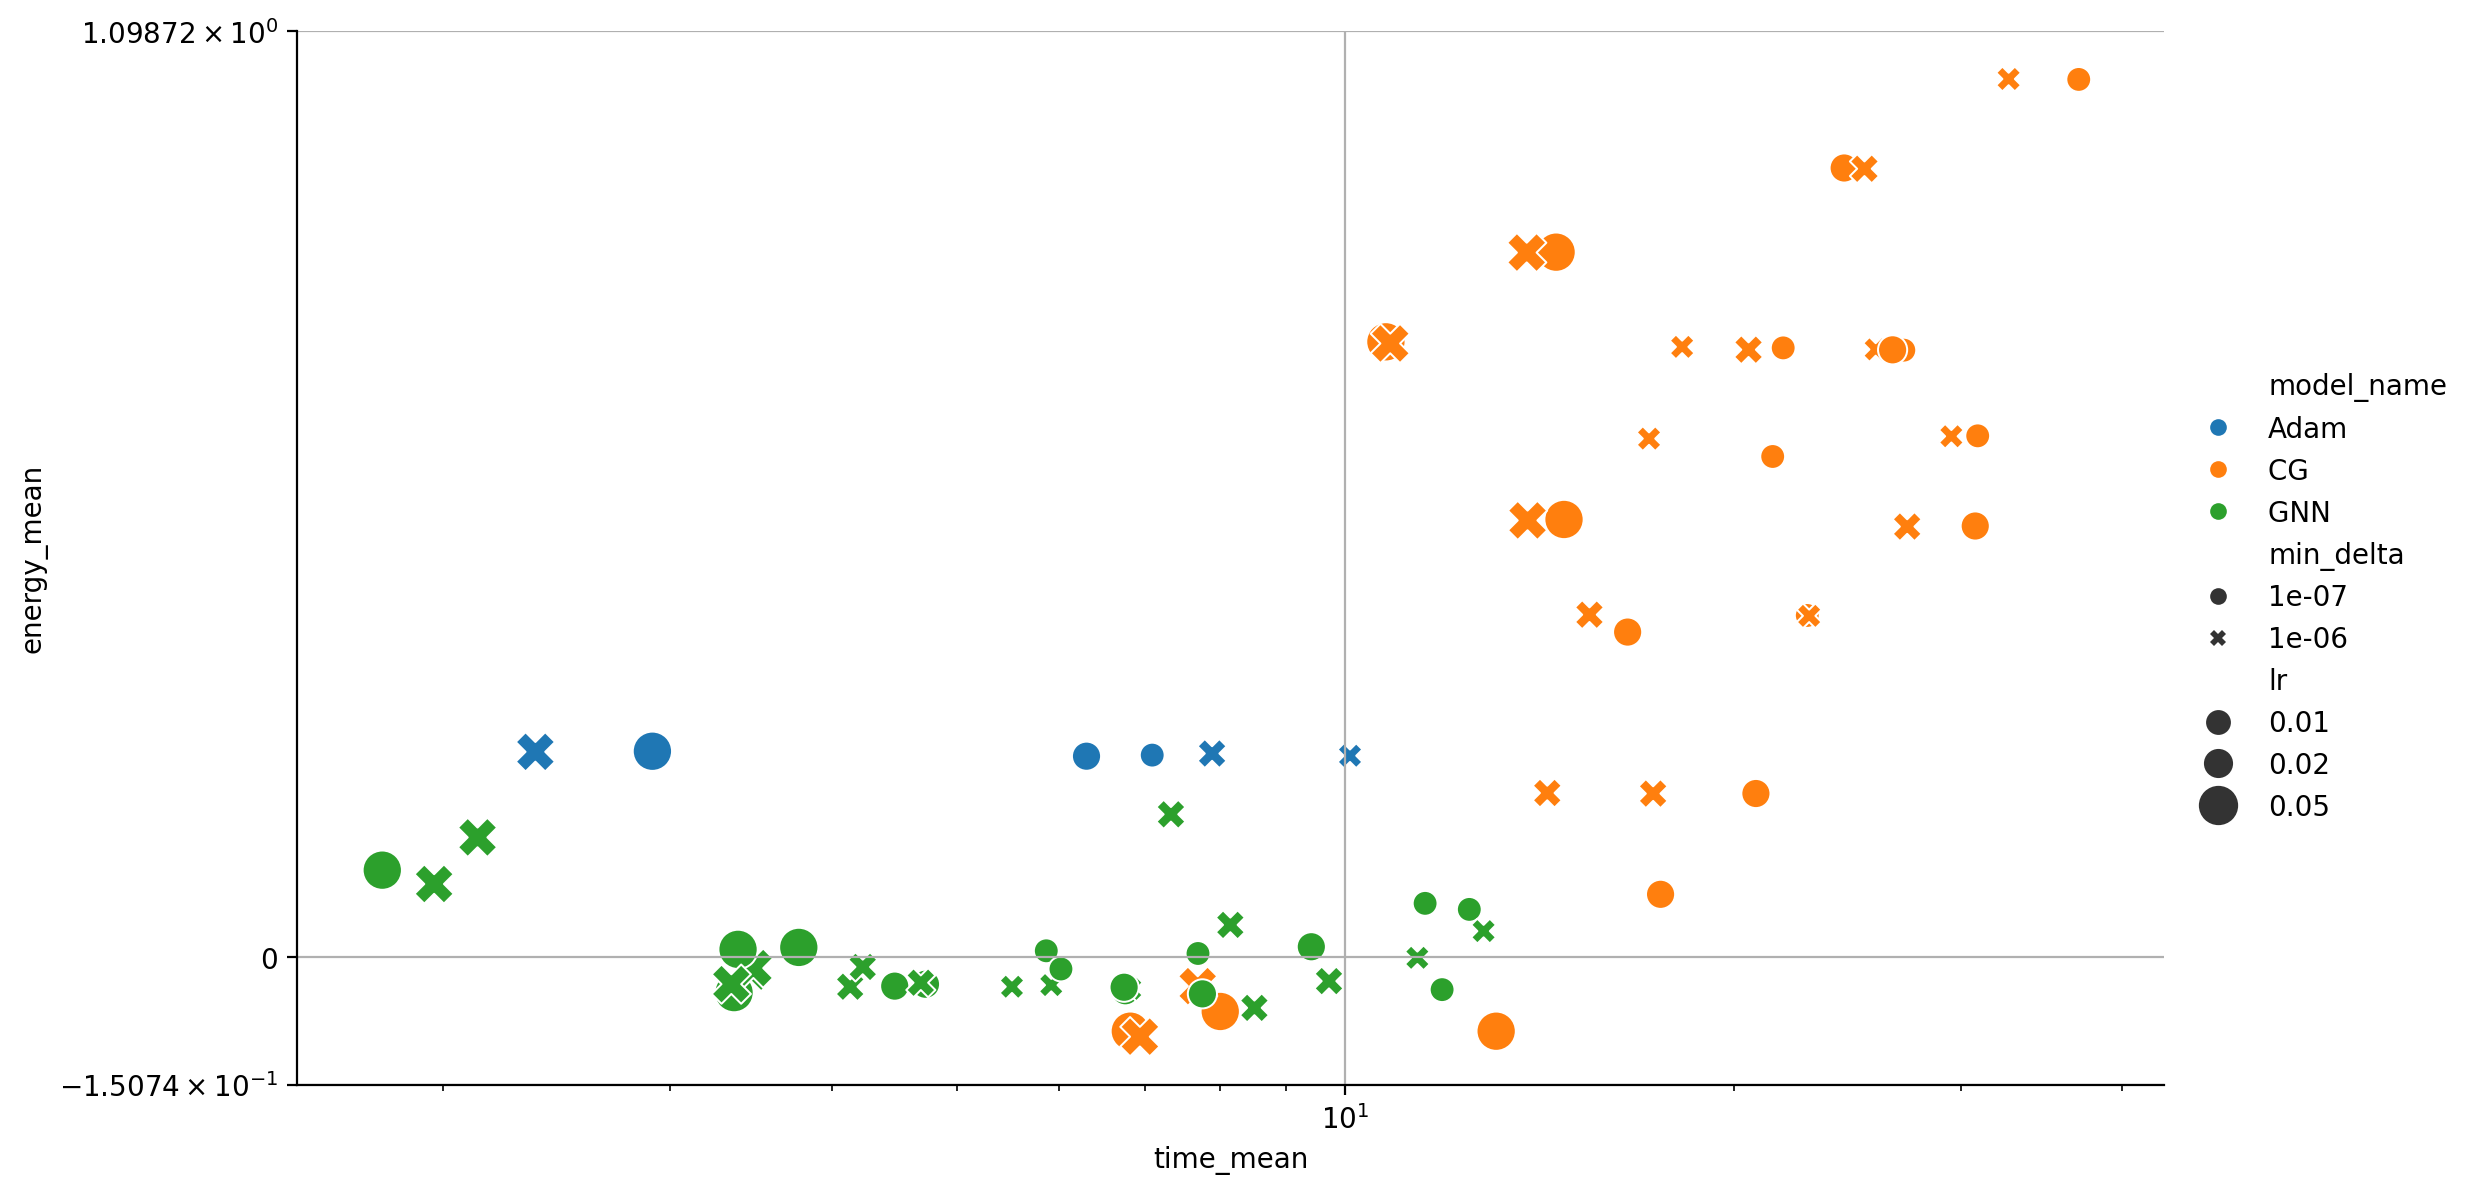

In [148]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

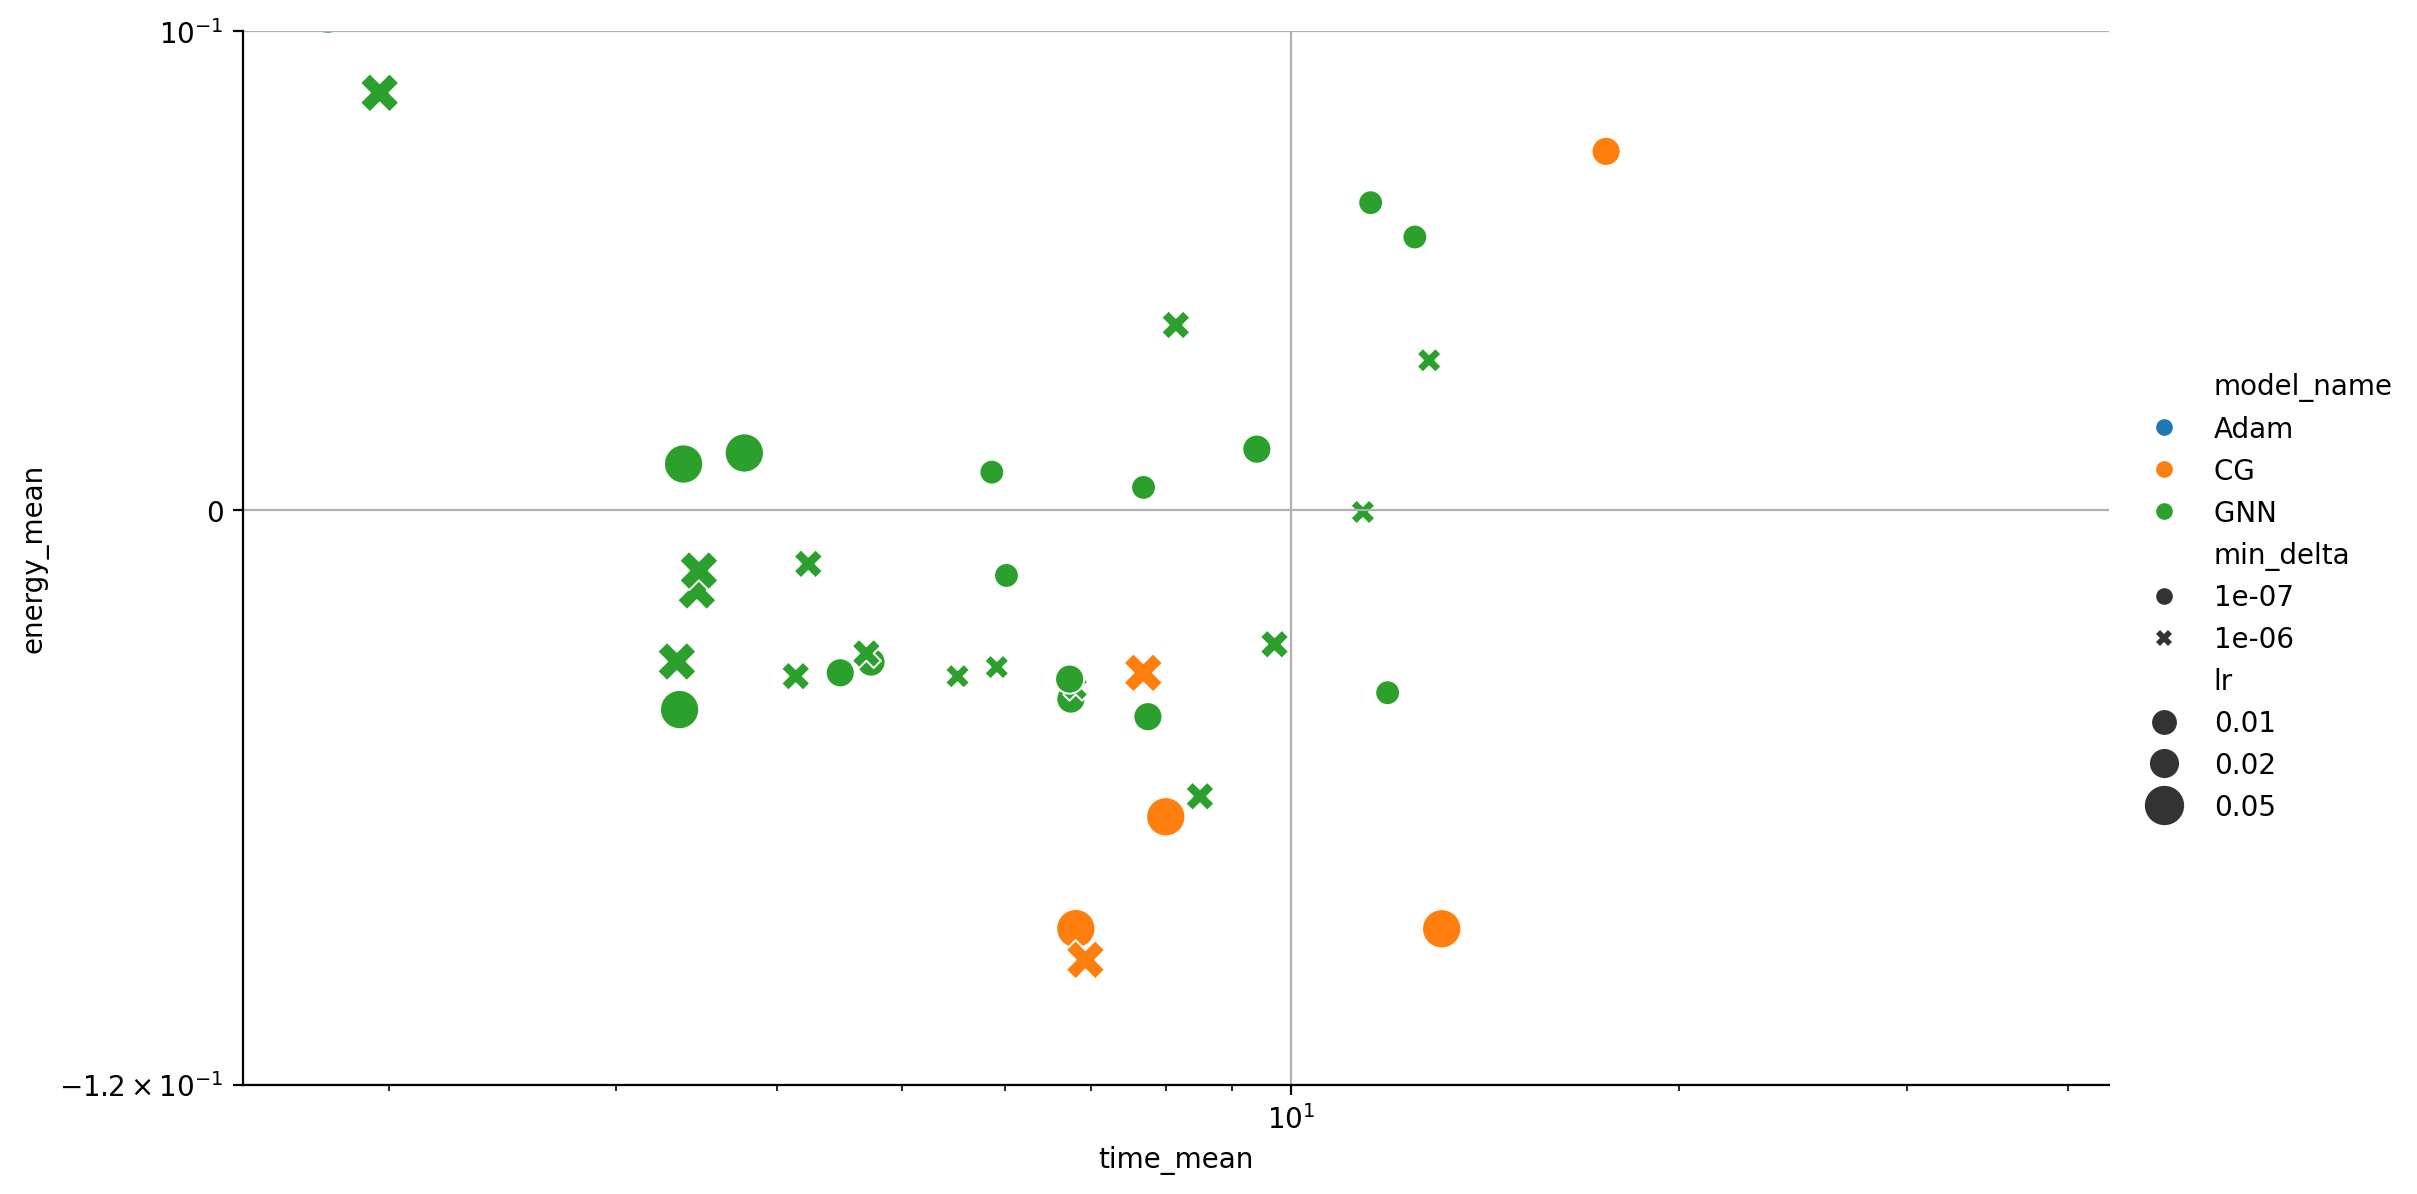

In [149]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

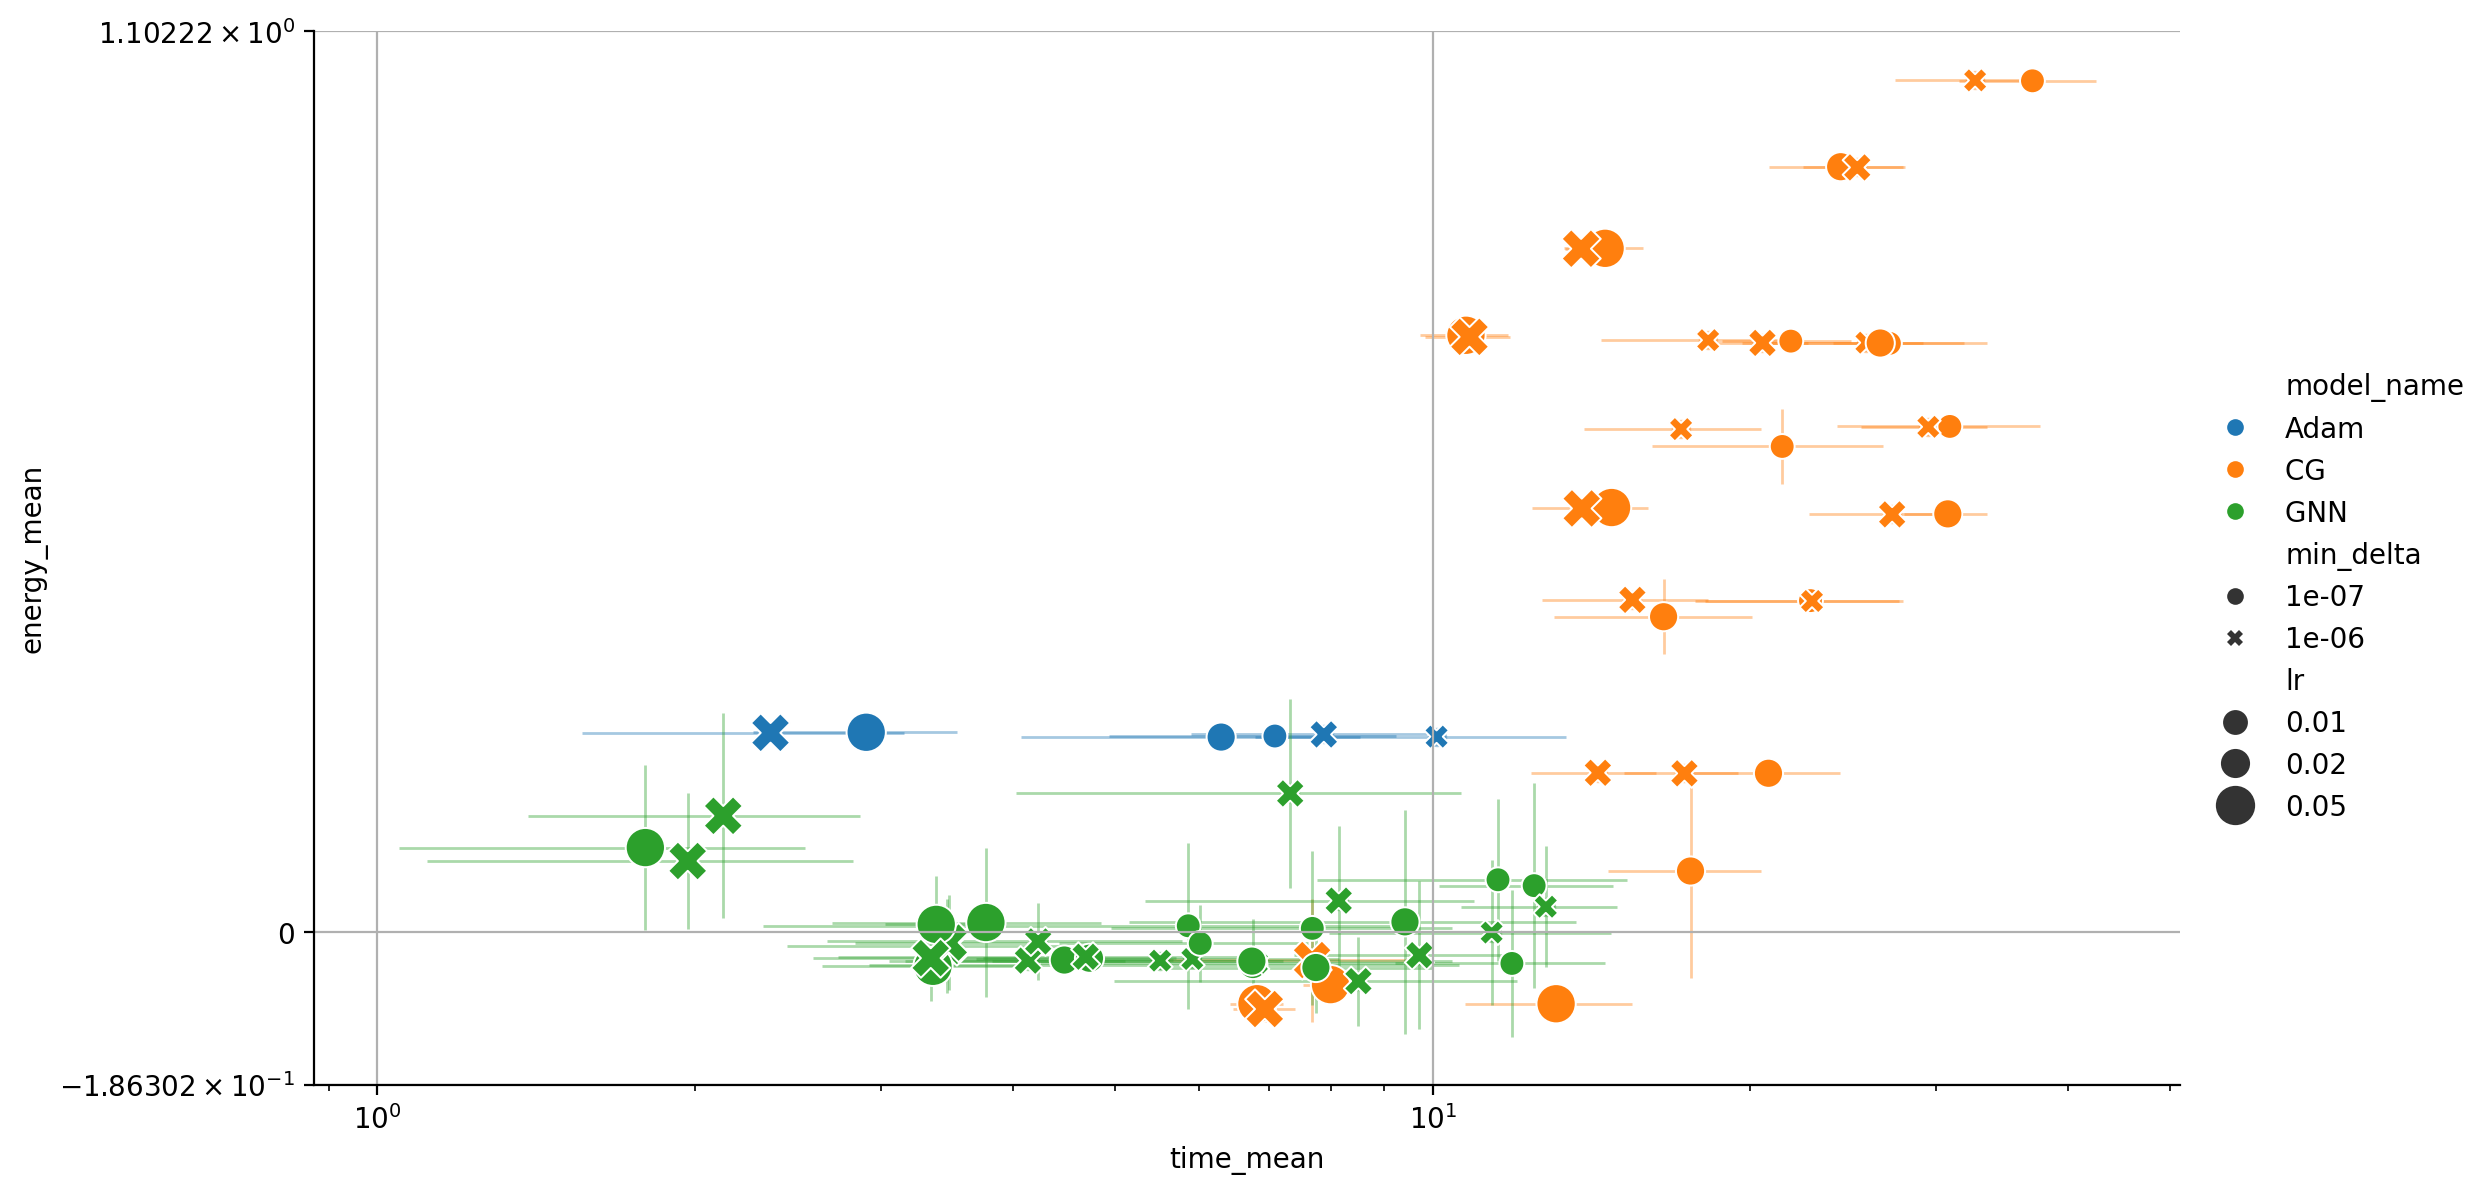

In [150]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

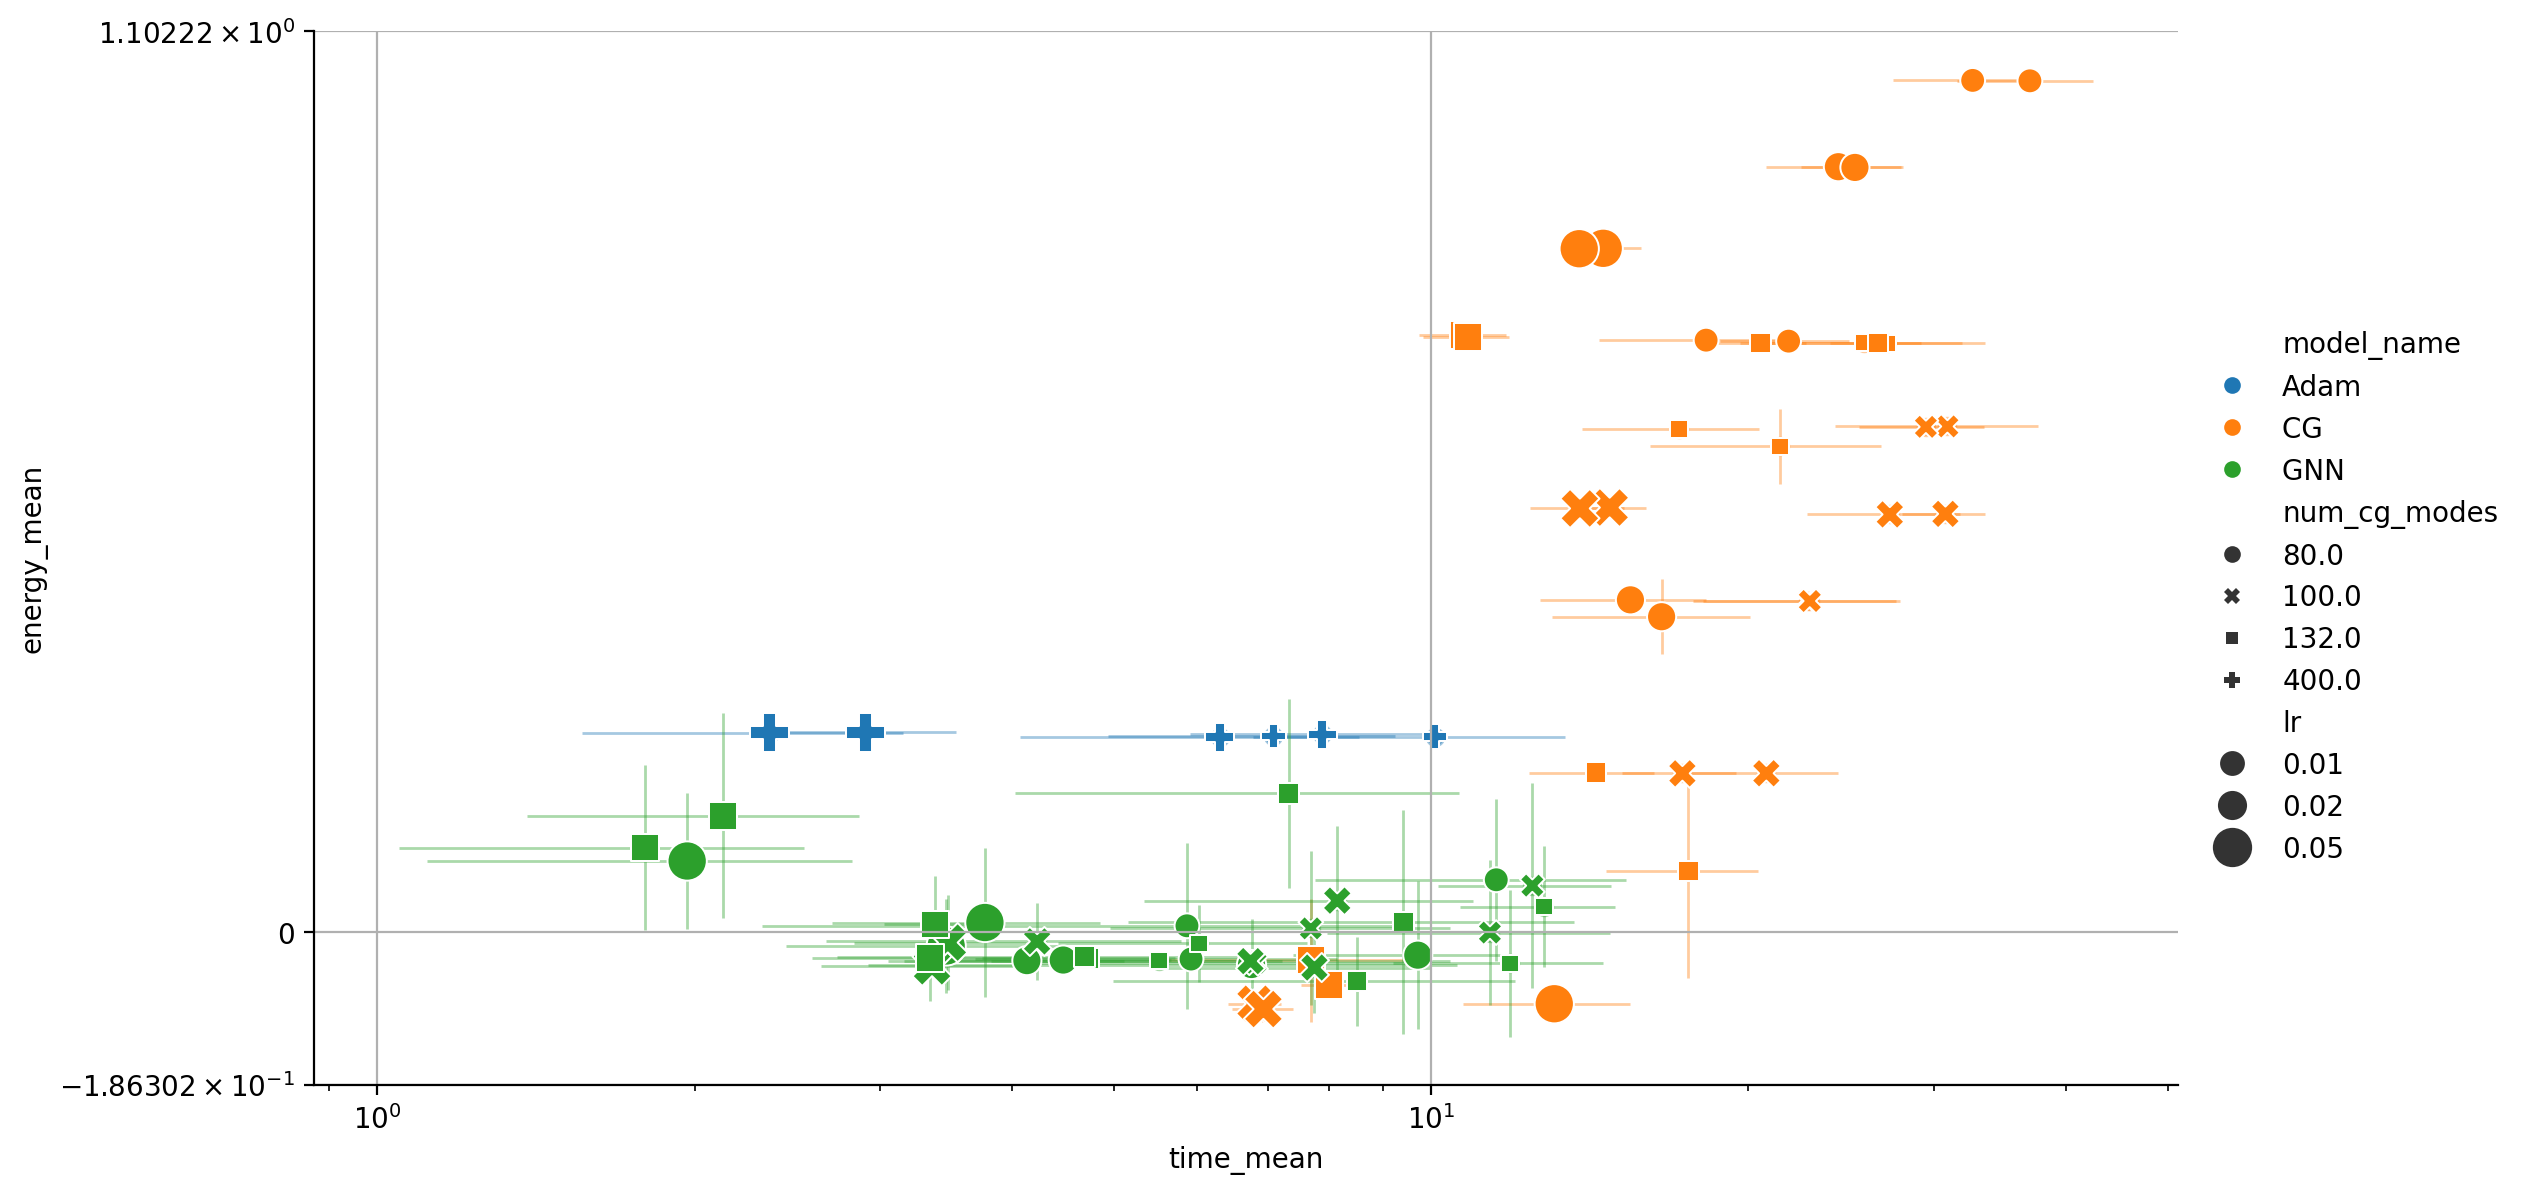

In [151]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

# plt.ylim(-.12, .10)
# # plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

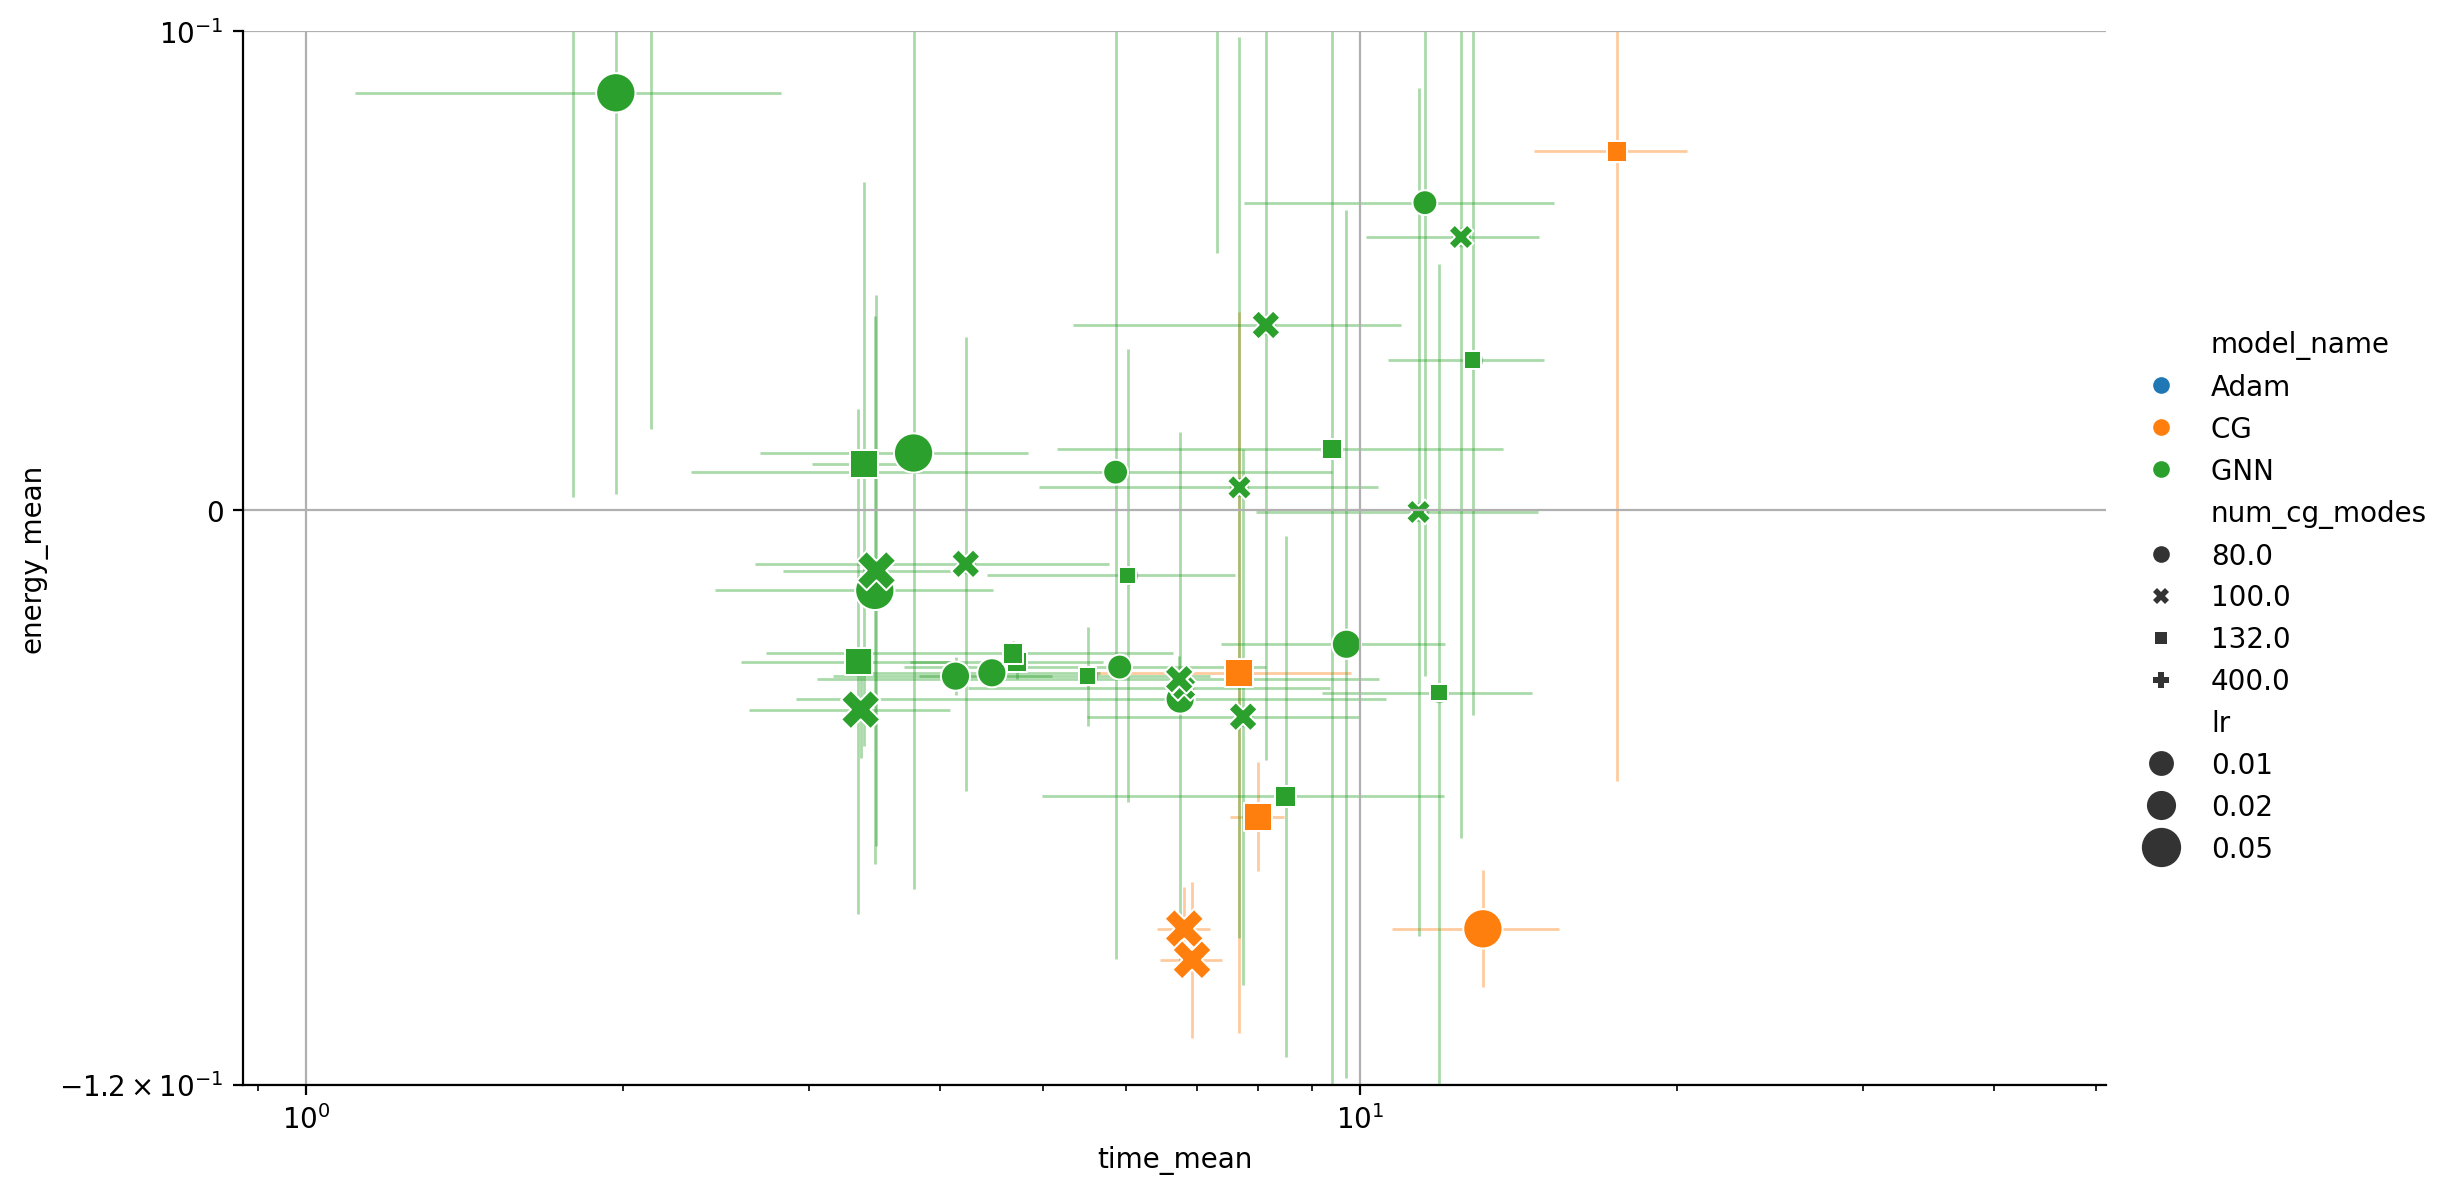

In [152]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time_mean', y='energy_mean', 
            hue='model_name', style='num_cg_modes', 
            kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

# since seaborn's error bars are not working, we will use matplotlib to plot the error bars
# we will use the std to plot the error bars, which are in df_cleaned[['time_std', 'energy_std']] columns
# plt.errorbar(df_cleaned['time_mean'], df_cleaned['energy_mean'], 
#             xerr=df_cleaned['time_std'], yerr=df_cleaned['energy_std'], 
#             color='orange', alpha = .4, lw = 1,
#             fmt='o', zorder = -1)

# we want to set the color of the errorbars to be the same as the color of the markers used by seaborn for that model_name
# we will use the same color palette used by seaborn to color the markers
# we will use the color_palette function from seaborn to get the color palette
# we will use the unique function to get the unique model_names
# we will use the to_dict function to convert the model_names to a dictionary
# we will use the map function to map the model_names to the colors
color_palette = sns.color_palette()
# we will use a for loop to plot the error bars for each model_name separately
# we will use the unique function to get the unique model_names
model_names = df_cleaned['model_name'].unique()
# we will use the model_names to loop over the model_names
for model_name in model_names:
    # we will use the loc function to filter the dataframe by model_name
    df_model = df_cleaned[df_cleaned['model_name'] == model_name]
    # we will use the plt.errorbar function to plot the error bars for the model_name
    plt.errorbar(df_model['time_mean'], df_model['energy_mean'], 
                xerr=df_model['time_std'], yerr=df_model['energy_std'], 
                color=model_color_dict[model_name], alpha = .4, lw = 1,
                fmt='o', zorder = -1)

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

# By type of model

In [20]:
# make another df where we take the model_name column and strip everything from "_LJ" to the end of the string and replace _ with a space
df_cleaned = df.copy()
# remove everything after _LJ in model_name. Ex: 'CG_LJ0.33_n400_d3' -> 'CG' 
# this means, we first need to find where _LJ is in the string, then remove everything after that
df_cleaned['model_name'] = df_cleaned['model_name'].apply(lambda x: x[:x.find('Bond_LJ')].replace('_', ' ') or "Adam")

In [21]:
df_cleaned

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std,num_nodes,lr_cg,cg_patience,cg_min_delta,cg_steps,cg_time,cg_energy,num_cg_modes,hidden_dims
0,Energy_LJ_2scale,Adam,0.247403,1.392278,0.05,0.1,20,1.000000e-06,1.838327,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Energy_LJ_2scale,CG,0.727117,9.580374,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,527.0,8.515158,0.749255,NaN,NaN
2,Energy_LJ_2scale,GNN,0.327568,10.335653,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,422.0,8.722153,0.328345,133.0,"[8, 4, 3]"
3,Energy_LJ_2scale,GNN,-0.053740,3.725070,0.05,0.1,20,1.000000e-06,1.838327,400,0.005,20.0,0.000010,34.0,1.192533,-0.018955,133.0,"[32, 16, 3]"
4,Energy_LJ_2scale,CG,0.518101,14.386985,0.05,0.1,20,1.000000e-06,1.838327,400,0.050,20.0,0.000010,822.0,13.196695,0.542127,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,Energy_LJ_2scale,GNN,0.378161,9.386935,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,220.0,4.761004,0.396002,100.0,"[8, 4, 3]"
566,Energy_LJ_2scale,GNN,-0.035773,7.855705,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,26.0,1.015844,-0.003536,100.0,"[32, 16, 3]"
567,Energy_LJ_2scale,CG,0.723125,19.358500,0.01,0.1,20,1.000000e-07,1.838327,400,0.100,20.0,0.000001,635.0,10.377081,0.760114,NaN,NaN
568,Energy_LJ_2scale,GNN,0.642706,10.697762,0.01,0.1,20,1.000000e-07,1.838327,400,0.010,20.0,0.000001,398.0,8.248155,0.643227,80.0,"[8, 4, 3]"


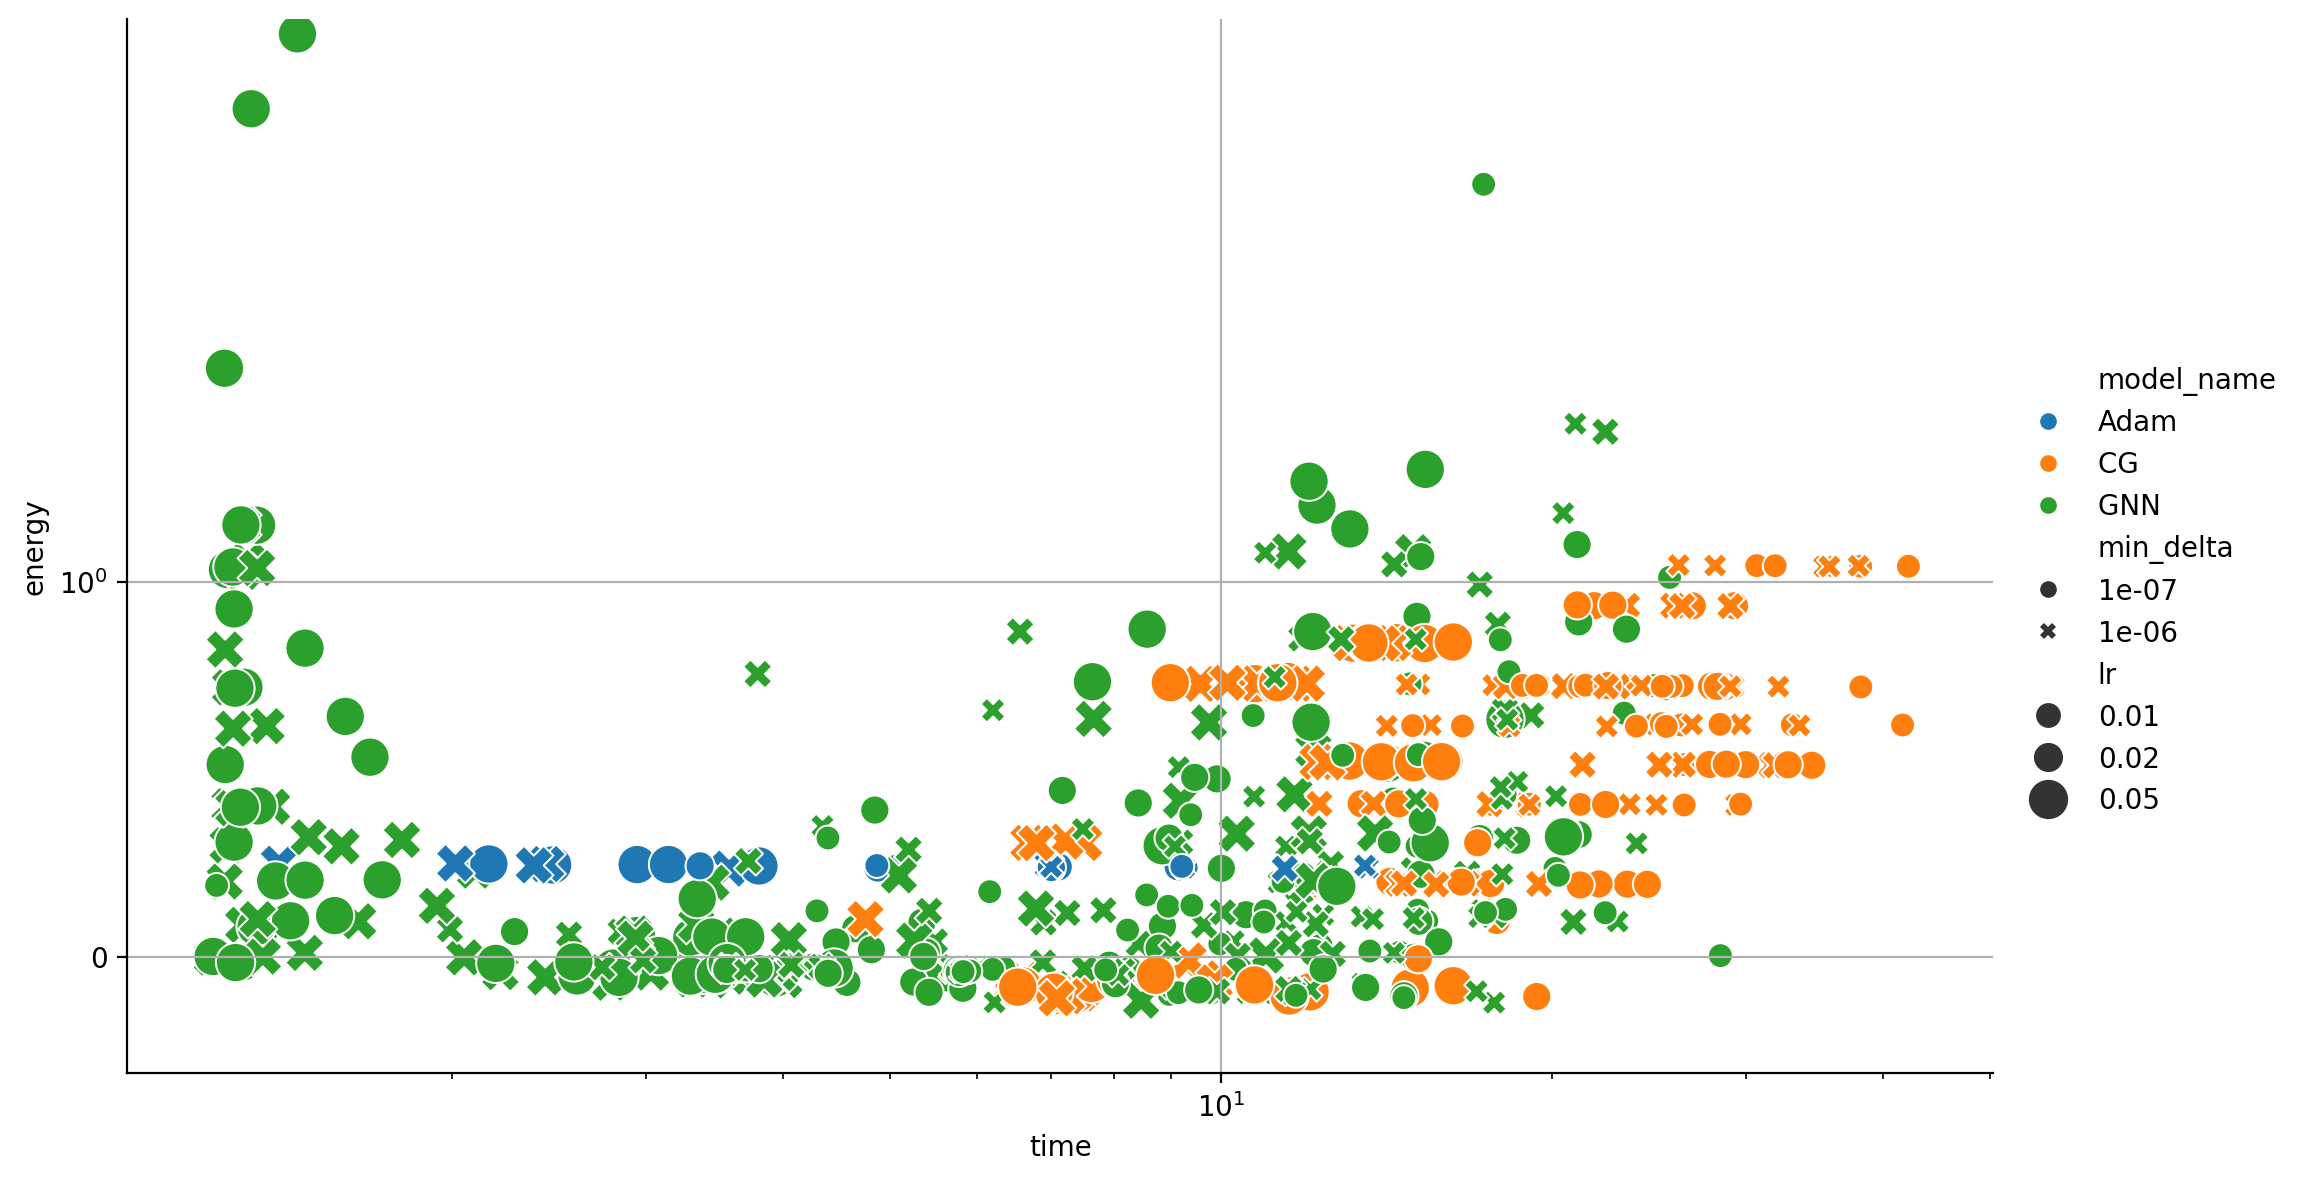

In [23]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr',
            height=6, aspect=1.7, sizes=(80, 200))

# plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()

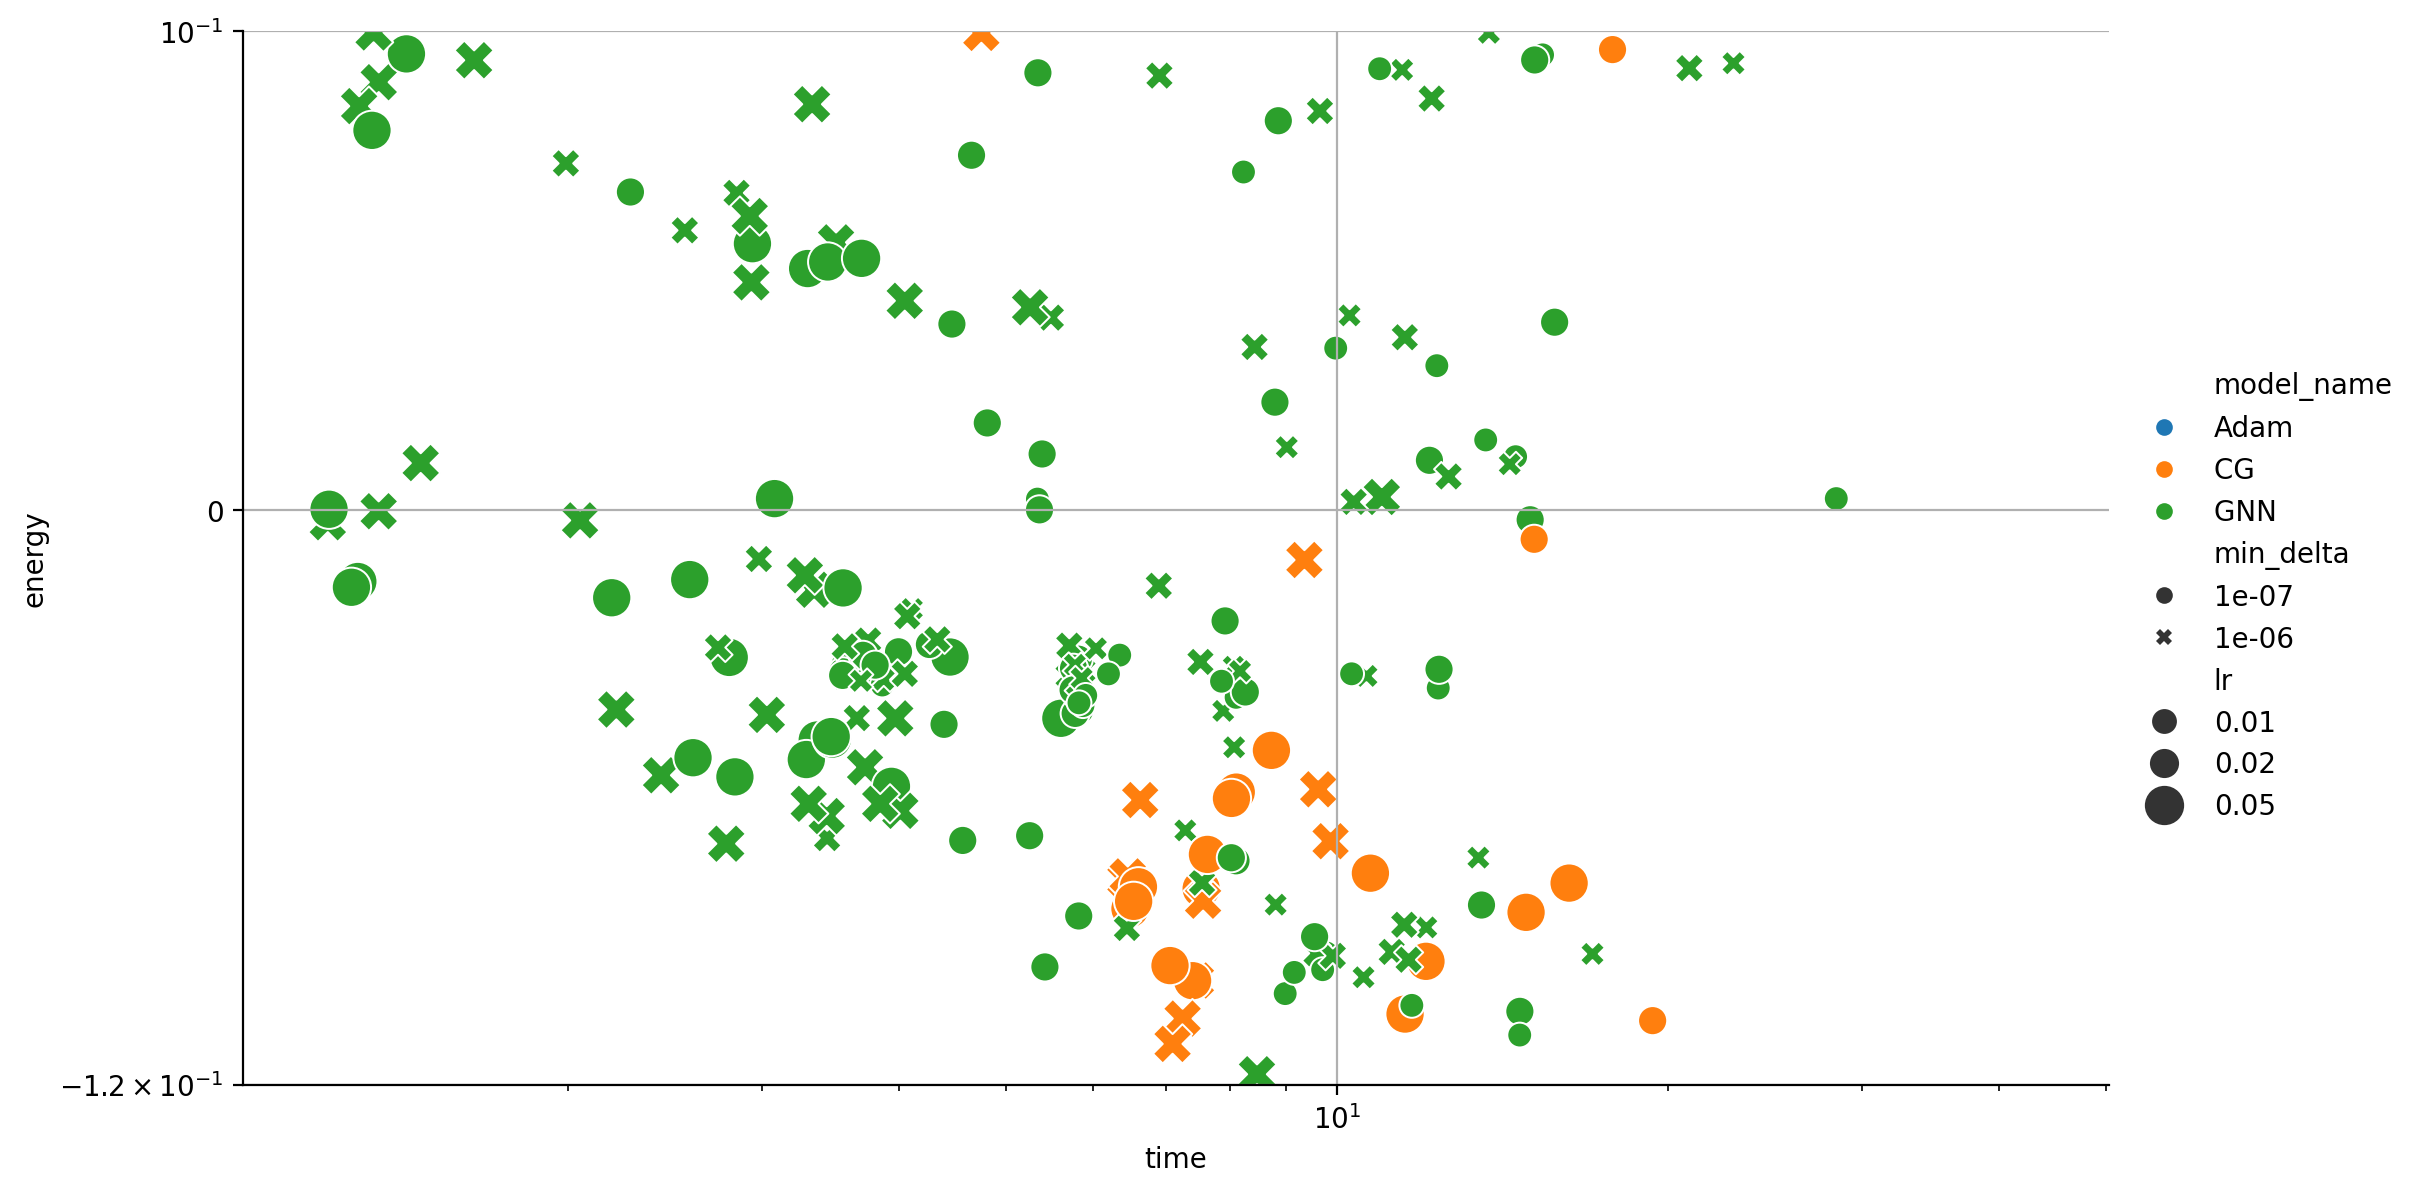

In [22]:

# plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='lr', height=6, aspect=1.7)
# plot with larger marker size 
sns.relplot(data=df_cleaned, x='time', y='energy', hue='model_name', style='min_delta', kind='scatter', size='lr', height=6, aspect=1.7, sizes=(80, 200))

plt.ylim(-.12, .10)
# plt.xlim(8,21)
plt.xscale('log')
plt.yscale('symlog')
plt.grid()